# Product Range Analysis

**Objective**<br>
Analyze 1 year worth of sales data for an e-commerce company. Investigate the product range, including categories & subcategories. Investigate their performance & contribution, as well as possible seasonal trends.

## Description of data

**`ecommerce_dataset_us.csv`**: invoice log
- `InvoiceNo`: order identifier
- `StockCode`: item identifier
- `Description`: item name
- `Quantity`
- `InvoiceDate`: order date
- `UnitPrice`: price per item
- `CustomerID`: customer identifier

<a class="anchor" id="toc"></a>
## Table of Contents

* 1. [Read files & import libraries](#read_import)
* 2. [General exploration of data](#explore)
* 3. [Pre-processing](#preprocess)
    * 3.1 [Column names & data types](#col_type)
    * 3.2 [Stock codes & product names](#codes_names)
        * 3.2.1 [Missing descriptions](#no_desc)
        * 3.2.2 [Identify stock codes with multiple descriptions](#stock_dupes)
        * 3.2.3 [Create `'notes'` column](#notes)
        * 3.2.4 [Build a code_name dictionary](#name_dict)
    * 3.3 [Create and fill the `'name'` column](#name)
    * 3.4 [Remove extraneous data](#remove_extra)
        * 3.4.1 [Rows with null names](#null_name)
        * 3.4.2 [Rows with notes](#note_rows)
        * 3.4.3 [Negative quantities](#neg_quantity)
        * 3.4.4 [Non-product codes](#np_codes)
        * 3.4.5 [Missing price & customer](#no_price_cust)
* 4. [Categorization](#categorize)
* 5. [Invoice analysis](#invoice_analysis)
    * 5.1 [Weekly sales](#weekly_sales)
    * 5.2 [Invoice size distributions](#invoice_size)
    * 5.3 [Customer invoice profiles](#cust_profile)
    * 5.4 [Distribution of product quantities](#unit_dist)
    * 5.5 [Relationship between invoice total, units purchase, and unique products](#totals_rel)
    * 5.6 [Outlier vs normal customers](#outlier_cust)
* 6. [Category analysis](#cat)
    * 6.1 [Relationships between category metrics](#cat_corr)
    * 6.2 [Overall top 10 categories](#top10_cats)
        * 6.2.1 [Top 10 categories by overall sales](#top10_overall)
        * 6.2.2 [Top 10 category monthly trends](#top10_monthly)
    * 6.3 [Monthly category rankings](#monthly_cat_rank)
    * 6.4 [Sub-category investigation](#subcat)
        * 6.4.1 [Lunch Accessories](#lunch)
        * 6.4.2 [Kitchen](#kitchen)
        * 6.4.3 [Home Decor](#home_decor)
* 7. [Hypothesis testing](#hyp_test)
    * 7.1 [Subcategory diversity on invoice totals](#subcat_totals)
    * 7.2 [Holiday invoice diversity](#holiday_div)
    * 7.3 [Subcategory size & order frequency](#subcat_freq)
* 8. [Conclusions](#conclusions)
    

<a class="anchor" id="read_import"></a>
## 1. Read files & import libraries

***The following packages may need to be installed to run the notebook***

In [1]:
#!pip install seaborn==0.11.2
#!pip install plotly==5.3.1
#!pip install sidetable
#!pip install -Uq ipywidgets

**Imports**

In [2]:
import pandas as pd
import sidetable as stb
import numpy as np
import scipy.stats as st
from collections import Counter

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

**Read data**

In [3]:
try:
    ecomm_data=pd.read_csv('ecommerce_dataset_us.csv', sep='\t')
except:
    ecomm_data=pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep='\t')

[Return to Table of Contents](#toc)

<a class="anchor" id="explore"></a>
## 2. General exploration of data

**Overview of the full table**

In [4]:
ecomm_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 157.9 MB


In [5]:
ecomm_data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID  
0  11/29/2018 08:26       2.55     17850.0  
1  11/29/2018 08:26       3.39     17850.0  
2  11/29/2018 08:26       2.75     17850.0  
3  11/29/2018 08:26       3.39     17850.0  
4  11/29/2018 08:26       3.39     17850.0

* Change InvoiceDate to datetime object
* Change CustomerID to integer

In [6]:
ecomm_data.stb.counts()

count  unique                           most_freq  \
Quantity     541909     722                                   1   
UnitPrice    541909    1630                                1.25   
StockCode    541909    4070                              85123A   
Description  540455    4223  WHITE HANGING HEART T-LIGHT HOLDER   
CustomerID   406829    4372                             17841.0   
InvoiceDate  541909   23260                    10/29/2019 14:41   
InvoiceNo    541909   25900                              573585   

             most_freq_count            least_freq  least_freq_count  
Quantity              148227                  -312                 1  
UnitPrice              50496               4505.17                 1  
StockCode               2313                 84482                 1  
Description             2369  wrongly sold as sets                 1  
CustomerID              7983               13703.0                 1  
InvoiceDate             1114      01/16/2019 10:01                 1  
InvoiceNo               1114               C566197                 1

* We have 4070 unique stockcodes. This is a fairly large product range.
* There are more descriptions than stockcodes. Check for stockcodes assigned to multiple items, mispellings, or other explanations.
* There are some very large invoices. The largest contains 1114 rows, likely representing 1114 different items.
* Customer 17841 appears 7983 times. This is some combination of repeat purchases and large invoices, since we know they have more rows than the largest invoice.
* There are letters present in both StockCode & InvoiceNo, so these cannot be converted to integers.
* Description does not seem to only contain product names. 'wrongly sold as sets'seems to be an explanation for a credit or error adjustment.

In [7]:
ecomm_data.describe()

Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000

* Negative value are present in Quantity. The minimum and maximum value match. This suggests returns or error adjustments.
* Negative UnitPrice values are also present

In [8]:
# Check for missing data
ecomm_data.stb.missing()

missing   total    percent
CustomerID    135080  541909  24.926694
Description     1454  541909   0.268311
InvoiceNo          0  541909   0.000000
StockCode          0  541909   0.000000
Quantity           0  541909   0.000000
InvoiceDate        0  541909   0.000000
UnitPrice          0  541909   0.000000

* Roughly a quarter of data is missing a customer ID
* Description also contains some nulls. 2.68% missing.

**Quantity**

In [9]:
# Check for rows where quantity is 0
ecomm_data[ecomm_data['Quantity']==0].count()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64

* No rows where the quantity is 0

In [10]:
# Check for rows with negative quantaties
ecomm_data[ecomm_data['Quantity']<0].count()

InvoiceNo      10624
StockCode      10624
Description     9762
Quantity       10624
InvoiceDate    10624
UnitPrice      10624
CustomerID      8905
dtype: int64

* There are 10624 rows with negative quantities. We should explore if these are all returns, though this seems unlikely for rows without a customer ID. They may also be internal inventory adjustments.

In [11]:
ecomm_data[ecomm_data['Quantity']<0].head()

InvoiceNo StockCode                       Description  Quantity  \
141   C536379         D                          Discount        -1   
154   C536383    35004C   SET OF 3 COLOURED  FLYING DUCKS        -1   
235   C536391     22556    PLASTERS IN TIN CIRCUS PARADE        -12   
236   C536391     21984  PACK OF 12 PINK PAISLEY TISSUES        -24   
237   C536391     21983  PACK OF 12 BLUE PAISLEY TISSUES        -24   

          InvoiceDate  UnitPrice  CustomerID  
141  11/29/2018 09:41      27.50     14527.0  
154  11/29/2018 09:49       4.65     15311.0  
235  11/29/2018 10:24       1.65     17548.0  
236  11/29/2018 10:24       0.29     17548.0  
237  11/29/2018 10:24       0.29     17548.0

* Invoices with negative quantities appear to start with C. Perhaps to represent credits.

**UnitPrice**

In [12]:
# Check for rows where price is 0
ecomm_data[ecomm_data['UnitPrice']==0].count()

InvoiceNo      2515
StockCode      2515
Description    1061
Quantity       2515
InvoiceDate    2515
UnitPrice      2515
CustomerID       40
dtype: int64

* There are 2515 rows where the price is 0. These could be discounts, free items, or services that are included but still need to be tracked. This should be investigated further.
* These rows are overwhelmingly missing customer information. Maybe these invoices are not sales, but other forms of inventory tracking.

In [13]:
ecomm_data[ecomm_data['UnitPrice']<0].count()

InvoiceNo      2
StockCode      2
Description    2
Quantity       2
InvoiceDate    2
UnitPrice      2
CustomerID     0
dtype: int64

In [14]:
ecomm_data[ecomm_data['UnitPrice']<0]

InvoiceNo StockCode      Description  Quantity       InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  08/10/2019 14:51   
299984   A563187         B  Adjust bad debt         1  08/10/2019 14:52   

        UnitPrice  CustomerID  
299983  -11062.06         NaN  
299984  -11062.06         NaN

* The only negative prices are for debt adjustments. These can be discarded from our dataset.

**Description**

In [15]:
#Most frequent descriptions
(ecomm_data.groupby('Description')['InvoiceNo'].count().reset_index()
           .sort_values('InvoiceNo',ascending=False).head(20))

Description  InvoiceNo
3918  WHITE HANGING HEART T-LIGHT HOLDER       2369
2915            REGENCY CAKESTAND 3 TIER       2200
1866             JUMBO BAG RED RETROSPOT       2159
2471                       PARTY BUNTING       1727
2054             LUNCH BAG RED RETROSPOT       1638
244        ASSORTED COLOUR BIRD ORNAMENT       1501
3195   SET OF 3 CAKE TINS PANTRY DESIGN        1473
2395     PACK OF 72 RETROSPOT CAKE CASES       1385
2046             LUNCH BAG  BLACK SKULL.       1350
2253     NATURAL SLATE HEART CHALKBOARD        1280
2753                             POSTAGE       1252
1864             JUMBO BAG PINK POLKADOT       1251
1710               HEART OF WICKER SMALL       1237
1833            JAM MAKING SET WITH JARS       1229
1879              JUMBO STORAGE BAG SUKI       1214
2439     PAPER CHAIN KIT 50'S CHRISTMAS        1210
1877   JUMBO SHOPPER VINTAGE RED PAISLEY       1202
2049                 LUNCH BAG CARS BLUE       1197
2057          LUNCH BAG SPACEBOY DESIGN        1192
1832              JAM MAKING SET PRINTED       1182

* POSTAGE is not a product name, though still an invoiced service

[Return to Table of Contents](#toc)

<a class="anchor" id="preprocess"></a>
## 3. Pre-processing

<a class="anchor" id="col_type"></a>
### 3.1 Column names & data types

In [16]:
# Copy of the dataframe to make adjustments to
ecomm = ecomm_data.copy()

**Change column names**

In [17]:
ecomm.columns = ['invoice', 'code', 'descr', 'quantity', 'dt', 'u_price','customer']

**Change data types**

Change the `'dt'` column to a datetime object <br>
Change `'customer'` to int type

In [18]:
# 'dt' to datetime
ecomm['dt'] = ecomm['dt'].astype('datetime64')
# Fill nulls in 'customer' with 0 then change to int type
ecomm['customer'] = ecomm['customer'].fillna(0).astype(int)

#Check names, types, and memory
ecomm.info(memory_usage ='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   invoice   541909 non-null  object        
 1   code      541909 non-null  object        
 2   descr     540455 non-null  object        
 3   quantity  541909 non-null  int64         
 4   dt        541909 non-null  datetime64[ns]
 5   u_price   541909 non-null  float64       
 6   customer  541909 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 124.3 MB


Now we have a dataframe that will be easier to work with

In [19]:
min_date = ecomm.dt.min().date()
max_date = ecomm.dt.max().date()
print('Date range: {} to {}'.format(min_date,max_date))

Date range: 2018-11-29 to 2019-12-07


[Return to Table of Contents](#toc)

<a class="anchor" id="codes_names"></a>
### 3.2 Stock codes & product names

We have stock codes and product names that are duplicated, as well as several rows missing product names. We will remove all duplicates for a 1-to-1 dictionary of stock codes and descriptions. This dictionary can then be used to fill missing product names.

<a class="anchor" id="no_desc"></a>
#### 3.2.1 Missing Descriptions
Explore data without a description. Look for any patterns.

In [20]:
no_name  = ecomm[ecomm.descr.isnull()]
no_name.stb.counts()

count  unique            most_freq  most_freq_count  \
u_price    1454       1                  0.0             1454   
customer   1454       1                    0             1454   
quantity   1454     266                    1              126   
code       1454     960                35965               10   
dt         1454    1121  2019-01-26 14:52:00                5   
invoice    1454    1454               536414                1   

                   least_freq  least_freq_count  
u_price                   0.0              1454  
customer                    0              1454  
quantity                 -343                 1  
code                    85125                 1  
dt        2019-07-26 10:20:00                 1  
invoice                536414                 1

All rows without a description have:
- u_price of 0
- no customer info (customer=0)
- separate invoices

In [21]:
noname_invoices = no_name.invoice.unique()
print('Rows from ecomm with the same invoices and no_name items:')
ecomm[ecomm.invoice.isin(noname_invoices) & (ecomm.u_price !=0)].shape[0]

Rows from ecomm with the same invoices and no_name items:


0

It is safe to assume these are inventory adjustments, and can be dropped before further processing.

In [22]:
ecomm = ecomm[ecomm.descr.notnull()]

[Return to Table of Contents](#toc)

<a class="anchor" id="stock_dupes"></a>
#### 3.2.2 Identify stock codes with multiple descriptions

In [23]:
# Make sure all codes have uppercase letters and no whitespaces
ecomm['code'] = ecomm['code'].str.upper().str.strip()

#Slice of ecomm where description is not null
ecomm_descr = ecomm[ecomm['descr'].notnull()]

In [24]:
# Descriptions & count grouped by code
code_descriptions = ecomm_descr.groupby('code')['descr'].agg(['nunique','unique']).reset_index()

print(code_descriptions['nunique'].value_counts())
code_descriptions.sort_values('nunique', ascending = False).head(10)

1    3203
2     512
3      98
4      26
5       5
6       2
8       1
7       1
Name: nunique, dtype: int64


code  nunique                                             unique
163    20713        8  [JUMBO BAG OWLS, wrongly marked. 23343 in box,...
1942   23084        7  [RABBIT NIGHT LIGHT, temp adjustment, allocate...
836    21830        6  [ASSORTED CREEPY CRAWLIES, MERCHANT CHANDLER C...
3392   85175        6  [CACTI T-LIGHT CANDLES, Amazon sold sets, dotc...
410    21181        5  [PLEASE ONE PERSON METAL SIGN, on cargo order,...
3389   85172        5  [HYACINTH BULB T-LIGHT CANDLES, Dotcom set, wr...
2184   23343        5  [JUMBO BAG VINTAGE CHRISTMAS , came coded as 2...
1985   23131        5  [MISTLETOE HEART WREATH CREAM, MISELTOE HEART ...
2778  72807A        5  [SET/3 ROSE CANDLE IN JEWELLED BOX, wet pallet...
2056   23203        4  [mailout, JUMBO BAG DOILEY PATTERNS, JUMBO BAG...

* Some descriptions seem to be reasons for cancellations/returns
* In some cases misspellings account for multiple descriptions

Count the number of occurances for each description to explore recurring descriptions.

In [25]:
#Create a list of every occurrence of each description
descriptions = []
for l in code_descriptions['unique']:
    for d in l:
        descriptions.append(d)

d_counts = pd.Series(Counter(descriptions)).sort_values(ascending=False)
d_counts.head(10)

check                     146
?                          47
damaged                    43
damages                    43
found                      25
sold as set on dotcom      20
adjustment                 15
Damaged                    14
thrown away                 9
Unsaleable, destroyed.      9
dtype: int64

* Recurring values don't appear to be products, as stated above.
* Product names tend to be capitalized, but these "explanations" tend to have lower_case letters.

These "explanations" should be moved to a separate column and replaced with the actual product name when available.

[Return to Table of Contents](#toc)

<a class='anchor' id= 'notes'></a>
#### 3.2.3 Create `'notes'` column

Create a new column `'notes'`, containing only descriptions that are not uppercase. 

In [26]:
# Condition for descriptions that are fully uppercase except for special chars and specifications such as "pack", "cm"
reg_cond = "([^A-Za-z ]|[ogcmxl]|pack)"

ecomm['notes'] = np.where(ecomm['descr'].str.replace(reg_cond,"", regex=True).str.isupper()==False,
                           ecomm['descr'].str.strip().str.lower(), #remove whitespace & set lowercase
                           None #fill the rest with null values
                          )

ecomm.head()

invoice    code                                descr  quantity  \
0  536365  85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365   71053                  WHITE METAL LANTERN         6   
2  536365  84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365  84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365  84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

                   dt  u_price  customer notes  
0 2018-11-29 08:26:00     2.55     17850  None  
1 2018-11-29 08:26:00     3.39     17850  None  
2 2018-11-29 08:26:00     2.75     17850  None  
3 2018-11-29 08:26:00     3.39     17850  None  
4 2018-11-29 08:26:00     3.39     17850  None

In [27]:
# Look at rows where 'notes' is not null
ecomm[ecomm['notes'].notnull()].head(15)

invoice          code                          descr  quantity  \
141   C536379             D                       Discount        -1   
2239   536569             M                         Manual         1   
2250   536569             M                         Manual         1   
2567   536592         21594  Dr. Jam's Arouzer Stress Ball         1   
4406   536779  BANK CHARGES                   Bank Charges         1   
5684   536865             M                         Manual         1   
6391   536941         22734                         amazon        20   
6392   536942         22139                         amazon        15   
6798   536981             M                         Manual         2   
7313   537032         21275                              ?       -30   
7976   537077             M                         Manual        12   
8530   537137             M                         Manual        36   
8587   537140             M                         Manual         1   
8588   537140             M                         Manual         1   
9038  C537164             D                       Discount        -1   

                      dt  u_price  customer                          notes  
141  2018-11-29 09:41:00    27.50     14527                       discount  
2239 2018-11-29 15:35:00     1.25     16274                         manual  
2250 2018-11-29 15:35:00    18.95     16274                         manual  
2567 2018-11-29 17:06:00     4.21         0  dr. jam's arouzer stress ball  
4406 2018-11-30 15:08:00    15.00     15823                   bank charges  
5684 2018-12-01 11:28:00     2.55         0                         manual  
6391 2018-12-01 12:08:00     0.00         0                         amazon  
6392 2018-12-01 12:08:00     0.00         0                         amazon  
6798 2018-12-01 14:26:00     0.85     14723                         manual  
7313 2018-12-01 16:50:00     0.00         0                              ?  
7976 2018-12-03 11:59:00     0.42     17062                         manual  
8530 2018-12-03 12:43:00     0.85     16327                         manual  
8587 2018-12-03 12:53:00     0.42     12748                         manual  
8588 2018-12-03 12:53:00     0.85     12748                         manual  
9038 2018-12-03 13:21:00    29.29     14527                       discount

There are some products that seem to have been entered with lowercase letters, such as "Dr. Jam's Arouzer Stress Ball". These will be revisted after creating the name column.

[Return to Table of Contents](#toc)

<a class='anchor' id= 'name_dict'></a>
#### 3.2.4 Build a code_name dictionary

Create a dictionary that contains one code to one description. First identify any codes with multiple descriptions & descriptions with multiple codes.

In [28]:
# Use descriptions where 'notes' is null to fill names
notes_null= ecomm[ecomm['notes'].isnull() & ecomm['descr'].notnull()].copy()
# Strip whitespace from descriptions
notes_null['descr'] = notes_null['descr'].str.strip()

# Slice of codes & descriptions only. This will be the base of our dictionary
code_descr = notes_null[['code','descr']].copy()
# Remove duplicated code-description pairs
code_descr.drop_duplicates(keep='first', inplace=True)

In [29]:
# List of all duplicated descriptions (match w/ multiple codes)
dup_descr = code_descr[code_descr['descr'].duplicated()]['descr'].unique()
             
# List of all duplicated codes (match with multiple descriptions)
dup_code = code_descr[code_descr['code'].duplicated()]['code'].unique()

print('Unique codes:', notes_null['code'].nunique())
print('Unique descr:', notes_null['descr'].nunique())
print('Code-descr pairs:', code_descr.shape[0])
print('Duplicated descr:', len(dup_descr))
print('Duplicated codes:', len(dup_code))

Unique codes: 3811
Unique descr: 4023
Code-descr pairs: 4055
Duplicated descr: 28
Duplicated codes: 225


**Duplicated descriptions**

There are only 28 duplicated descriptions. Identify & explore descriptions that match multiple codes.

In [30]:
# Print a table of duplicated descriptions and their codes
dup_descr_codes = (code_descr[code_descr['descr'].isin(dup_descr)]
                       .groupby('descr')['code'].unique().reset_index()
                  )
dup_descr_codes

descr                      code
0                            AMAZON    [72807A, 22848, 22925]
1               BATHROOM METAL SIGN            [82580, 21171]
2                             CHECK    [85035A, 21618, 23406]
3      COLOURING PENCILS BROWN TUBE            [10133, 10135]
4        COLUMBIAN CANDLE RECTANGLE            [72133, 72131]
5            COLUMBIAN CANDLE ROUND     [72127, 72130, 72128]
6   EAU DE NILE JEWELLED PHOTOFRAME          [85023B, 85024B]
7       FRENCH FLORAL CUSHION COVER            [20840, 20837]
8      FRENCH LATTICE CUSHION COVER            [20835, 20838]
9      FRENCH PAISLEY CUSHION COVER            [20839, 20836]
10               FROSTED WHITE BASE            [79403, 79406]
11             HEART T-LIGHT HOLDER            [21814, 85118]
12   METAL SIGN,CUPCAKE SINGLE HOOK  [82613B, 82613C, 82613A]
13  PAPER LANTERN 9 POINT SNOW STAR            [23041, 23040]
14     PINK BUTTERFLY CUSHION COVER            [84905, 84906]
15    PINK FAIRY CAKE CUSHION COVER          [47586A, 47585A]
16    PINK FLOCK GLASS CANDLEHOLDER            [79329, 79331]
17       PINK FLOWERS RABBIT EASTER          [35909B, 35910B]
18        PINK JEWELLED PHOTO FRAME          [84712B, 84708B]
19          RETRO PLASTIC 70'S TRAY          [79190A, 79192A]
20         RETRO PLASTIC DAISY TRAY          [79190D, 79191D]
21         RETRO PLASTIC POLKA TRAY          [79191B, 79190B]
22        ROSE DU SUD CUSHION COVER            [21003, 20997]
23     ROUND BLUE CLOCK WITH SUCKER          [81952B, 81953B]
24    SET OF 4 FAIRY CAKE PLACEMATS          [84509B, 84509G]
25    SQUARE CHERRY BLOSSOM CABINET            [84665, 84666]
26         STORAGE TIN VINTAGE LEAF            [23235, 23244]
27      WHITE BAMBOO RIBS LAMPSHADE            [40001, 40003]

* AMAZON & CHECK should have moved to the 'notes' column, but difference in cases meant the capitalized version was skipped. We will remove these from `dup_descr_codes` and add them to `'notes'`.
* Most items have codes that are very close together. These are likely similar items in different styles, sizes, or colors. First we will check if any of these codes are also in dup_code. Any item that is not also in dup_code can simply be assigned to the first code in the list.

In [31]:
#Remove AMAZON & CHECK from 'dup_descr_codes'
cond_AC = dup_descr_codes[dup_descr_codes['descr'].isin(['AMAZON','CHECK'])]
dup_descr_codes.drop(cond_AC.index, inplace = True)

In [32]:
# List of all codes in 'dup_descr_codes'
flat_dcodes = [item for sublist in dup_descr_codes['code'] for item in sublist]

**Overlapping duplicated codes & descriptions**

In [33]:
# Table of duplicated codes and lists of their matching descriptions, not including AMAZON/CHECK descriptions
cond_AC_2 = !(code_descr[code_descr['descr'].isin(['AMAZON','CHECK'])])
cond_dupc = code_descr['code'].isin(dup_code)

dup_code_descrs = (code_descr[cond_AC_2 & cond_dupc].groupby('code')['descr']
                                                    .agg(['nunique','unique'])
                                                    .reset_index()
                  )
dup_code_descrs.head(10)

code  nunique                                             unique
0  16156L        2                    [WRAP, CAROUSEL, WRAP CAROUSEL]
1  17107D        3  [FLOWER FAIRY,5 SUMMER B'DRAW LINERS, FLOWER F...
2   20622        2            [VIPPASSPORT COVER, VIP PASSPORT COVER]
3   20681        2            [PINK POLKADOT CHILDRENS UMBRELLA, MIA]
4   20725        2    [LUNCH BAG RED RETROSPOT, LUNCH BAG RED SPOTTY]
5   20914        2  [SET/5 RED RETROSPOT LID GLASS BOWLS, SET/5 RE...
6   21090        2           [SET/6 COLLAGE PAPER PLATES, WET/MOULDY]
7   21109        2  [LARGE CAKE TOWEL, CHOCOLATE SPOTS, LARGE CAKE...
8   21112        2  [SWISS ROLL TOWEL, PINK  SPOTS, SWISS ROLL TOW...
9   21175        2  [GIN + TONIC DIET METAL SIGN, GIN AND TONIC DI...

In [34]:
dup_code_descrs['nunique'].value_counts()

2    208
3     15
4      2
Name: nunique, dtype: int64

In [35]:
# List of all descriptions in dup_code_descrs
flat_cdesc = [item for sublist in dup_code_descrs['unique'] for item in sublist]

In [36]:
# Codes that appear in both duplicate sets
codes_in_both = dup_code_descrs[dup_code_descrs['code'].isin(flat_dcodes)]['code'].unique()
# Descriptions that appear in both duplicate sets
descr_in_both = dup_descr_codes[dup_descr_codes['descr'].isin(flat_cdesc)]['descr'].unique()

In [37]:

cond_cd_both = notes_null['code'].isin(codes_in_both) | notes_null['descr'].isin(descr_in_both)

notes_null[cond_cd_both].groupby(['code','descr'])['invoice'].count()

code   descr                          
23040  PAPER LANTERN 9 POINT SNOW STAR     43
23041  PAPER LANTERN 6 POINT SNOW STAR      6
       PAPER LANTERN 9 POINT SNOW STAR     49
23235  BISCUIT TIN VINTAGE LEAF             3
       STORAGE TIN VINTAGE LEAF           112
23244  CANNISTER VINTAGE LEAF DESIGN        2
       ROUND STORAGE TIN VINTAGE LEAF     108
       STORAGE TIN VINTAGE LEAF             7
84905  PINK BUTTERFLY CUSHION COVER        20
84906  PINK B'FLY C/COVER W BOBBLES         7
       PINK BUTTERFLY CUSHION COVER         6
Name: invoice, dtype: int64

We will assume that sales were made by stock code, not name, since this is how warehouses generally identify items for delivery. For the 2 codes with only one description (23040, 84905), we will assume this is the correct code-name match. These descriptions will be removed from their alternate codes. For the other items, we will use the name with the highest frequency.

In [38]:
#Change code_descr
code_descr.loc[code_descr['code']== '23041', 'descr'] = 'PAPER LANTERN 6 POINT SNOW STAR'
code_descr.loc[code_descr['code']== '23235', 'descr'] = 'STORAGE TIN VINTAGE LEAF'
code_descr.loc[code_descr['code']== '23244', 'descr'] = 'ROUND STORAGE TIN VINTAGE LEAF'
code_descr.loc[code_descr['code']== '84906', 'descr'] = 'PINK BUTTERFLY CUSHION COVER BOBBLES'


# Drop AMAZON & CHECK from code_desc
cond = code_descr[code_descr['descr'].isin(['AMAZON','CHECK'])]
code_descr.drop(cond.index, inplace = True)

# Remove new duplicate pairs
code_descr.drop_duplicates(keep='first',inplace=True)

code_descr.shape[0]

4044

**Explore codes with multiple descriptions**
* Start with codes with 3+ descriptions. Look for any patterns.

In [39]:
# List of codes with 3+ descriptions
code_list_3plus = dup_code_descrs[dup_code_descrs['nunique']>2]['code'].unique()
# Look at these codes and all their descriptions. Determine which to keep.
code_descr[code_descr['code'].isin(code_list_3plus)].sort_values('code')

code                                descr
6467    17107D  FLOWER FAIRY,5 SUMMER B'DRAW LINERS
347764  17107D    FLOWER FAIRY 5 SUMMER DRAW LINERS
315743  17107D         FLOWER FAIRY 5 DRAWER LINERS
1030     22776          SWEETHEART CAKESTAND 3 TIER
3414     22776         CAKESTAND, 3 TIER, LOVEHEART
320506   22776         SWEETHEART 3 TIER CAKE STAND
17260    22937      BAKING MOULD CHOCOLATE CUPCAKES
19781    22937     BAKING MOULD CHOCOLATE CUP CAKES
29402    22937       BAKING MOULD CUPCAKE CHOCOLATE
107430   23126            DOLLCRAFT GIRL AMELIE KIT
108342   23126            FELTCRAFT GIRL AMELIE KIT
113900   23126                DOLLCRAFT GIRL AMELIE
186760   23131          MISELTOE HEART WREATH WHITE
285379   23131          MISELTOE HEART WREATH CREAM
169208   23131         MISTLETOE HEART WREATH CREAM
237422   23196        RETRO LEAVES MAGNETIC NOTEPAD
238991   23196   RETO LEAVES MAGNETIC SHOPPING LIST
246802   23196       LEAVES MAGNETIC  SHOPPING LIST
252851   23196        VINTAGE LEAF MAGNETIC NOTEPAD
292655   23203              JUMBO BAG VINTAGE DOILY
290977   23203             JUMBO BAG VINTAGE DOILEY
178609   23203            JUMBO BAG DOILEY PATTERNS
292677   23209              LUNCH BAG VINTAGE DOILY
290979   23209             LUNCH BAG VINTAGE DOILEY
179020   23209             LUNCH BAG DOILEY PATTERN
55190    23231                   WRAP DOILEY DESIGN
291522   23231                 WRAP  VINTAGE DOILEY
295527   23231                  WRAP  VINTAGE DOILY
290770   23236           STORAGE TIN VINTAGE DOILEY
292790   23236            STORAGE TIN VINTAGE DOILY
220496   23236                   DOILEY BISCUIT TIN
218408   23236                   DOILEY STORAGE TIN
295685   23240    SET OF 4 KNICK KNACK TINS  DOILEY
216356   23240     SET OF 4 KNICK KNACK TINS DOILEY
292165   23240      SET OF 4 KNICK KNACK TINS DOILY
218646   23244       ROUND STORAGE TIN VINTAGE LEAF
379961   23366      SET 12 COLOURING PENCILS DOILEY
353310   23366       SET 12 COLOURING PENCILS DOILY
353394   23366         SET 12 COLOUR PENCILS DOILEY
353697   23370       SET 36 COLOURING PENCILS DOILY
353393   23370         SET 36 COLOUR PENCILS DOILEY
379959   23370      SET 36 COLOURING PENCILS DOILEY
324811   23396              BUTTERFLY CUSHION COVER
325537   23396    LA JARDIN BOTANIQUE CUSHION COVER
345377   23396    LE JARDIN BOTANIQUE CUSHION COVER
330151   23413           VINTAGE COFFEE GRINDER BOX
405348   23413  DECROTIVEVINTAGE COFFEE GRINDER BOX
418169   23413       DECORATIVE VINTAGE COFFEE  BOX
378493   23535              WALL ART BICYCLE SAFETY
371806   23535              BICYCLE SAFTEY WALL ART
373726   23535              WALL ART BICYCLE SAFTEY

* A lot of duplicates caused by mispellings or rearranging words.
* Fix spelling of "DOILY" in all cases
* Change all instances of the word color/colour/coloring/colouring to "COLOR" 

In [40]:
code_descr['descr'] = (code_descr['descr']
                           .str.replace('DOILEY', 'DOILY', regex=True)
                           .str.replace("COLORING |COLOUR |COLOURING ", 'COLOR ', regex=True)
                      )
# Remove any new code-descr duplicates
code_descr.drop_duplicates(keep='first', inplace=True)

In [41]:
code_descr[code_descr['code'].isin(code_list_3plus)].sort_values('code')

code                                descr
6467    17107D  FLOWER FAIRY,5 SUMMER B'DRAW LINERS
347764  17107D    FLOWER FAIRY 5 SUMMER DRAW LINERS
315743  17107D         FLOWER FAIRY 5 DRAWER LINERS
1030     22776          SWEETHEART CAKESTAND 3 TIER
3414     22776         CAKESTAND, 3 TIER, LOVEHEART
320506   22776         SWEETHEART 3 TIER CAKE STAND
17260    22937      BAKING MOULD CHOCOLATE CUPCAKES
19781    22937     BAKING MOULD CHOCOLATE CUP CAKES
29402    22937       BAKING MOULD CUPCAKE CHOCOLATE
108342   23126            FELTCRAFT GIRL AMELIE KIT
107430   23126            DOLLCRAFT GIRL AMELIE KIT
113900   23126                DOLLCRAFT GIRL AMELIE
169208   23131         MISTLETOE HEART WREATH CREAM
186760   23131          MISELTOE HEART WREATH WHITE
285379   23131          MISELTOE HEART WREATH CREAM
238991   23196   RETO LEAVES MAGNETIC SHOPPING LIST
252851   23196        VINTAGE LEAF MAGNETIC NOTEPAD
237422   23196        RETRO LEAVES MAGNETIC NOTEPAD
246802   23196       LEAVES MAGNETIC  SHOPPING LIST
290977   23203              JUMBO BAG VINTAGE DOILY
178609   23203             JUMBO BAG DOILY PATTERNS
290979   23209              LUNCH BAG VINTAGE DOILY
179020   23209              LUNCH BAG DOILY PATTERN
291522   23231                  WRAP  VINTAGE DOILY
55190    23231                    WRAP DOILY DESIGN
218408   23236                    DOILY STORAGE TIN
290770   23236            STORAGE TIN VINTAGE DOILY
220496   23236                    DOILY BISCUIT TIN
216356   23240      SET OF 4 KNICK KNACK TINS DOILY
295685   23240     SET OF 4 KNICK KNACK TINS  DOILY
218646   23244       ROUND STORAGE TIN VINTAGE LEAF
353310   23366           SET 12 COLOR PENCILS DOILY
353393   23370           SET 36 COLOR PENCILS DOILY
324811   23396              BUTTERFLY CUSHION COVER
325537   23396    LA JARDIN BOTANIQUE CUSHION COVER
345377   23396    LE JARDIN BOTANIQUE CUSHION COVER
330151   23413           VINTAGE COFFEE GRINDER BOX
405348   23413  DECROTIVEVINTAGE COFFEE GRINDER BOX
418169   23413       DECORATIVE VINTAGE COFFEE  BOX
371806   23535              BICYCLE SAFTEY WALL ART
373726   23535              WALL ART BICYCLE SAFTEY
378493   23535              WALL ART BICYCLE SAFETY

* Many duplicated have already disappeared. Let's create updated lists & slices to work from.

**Update duplicate lists with adjusted `code_descr` pairs**

In [42]:
# List of all duplicated descriptions (match w/ multiple codes)
dup_descr_upd = code_descr[code_descr['descr'].duplicated()]['descr'].unique()
             
# List of all duplicated codes (match with multiple descriptions)
dup_code_upd = code_descr[code_descr['code'].duplicated()]['code'].unique()

print('Unique codes:', code_descr['code'].nunique())
print('Code-descr pairs:', code_descr.shape[0])
print('Duplicated descr, previous:', len(dup_descr))
print('Duplicated descr, updated:', len(dup_descr_upd))
print('Duplicated codes, previous:', len(dup_code))
print('Duplicated codes, updated:', len(dup_code_upd))

Unique codes: 3811
Code-descr pairs: 4032
Duplicated descr, previous: 28
Duplicated descr, updated: 23
Duplicated codes, previous: 225
Duplicated codes, updated: 210


**Create a base dictionary**

Create code_name dictionary with all pairs that do not contain duplicated values. All cleaned pairs will be appended to this dictionary.

In [43]:
# Create a base dict of all pairs without duplicates
c1 = np.logical_not(code_descr['descr'].isin(dup_descr_upd))
c2 = np.logical_not(code_descr['code'].isin(dup_code_upd))
code_name = code_descr[c1 & c2].set_index('code').to_dict()['descr']
len(code_name)

3553

**Remove excess codes from descriptions**

For each description with multiple codes, select the first code in the code list. 

In [44]:
dup_descr_codes_upd = (code_descr[code_descr['descr'].isin(dup_descr_upd)]
                           .groupby('descr')['code'].unique()
                           .str[0].reset_index()
                      )
dup_descr_codes_upd

descr    code
0               BATHROOM METAL SIGN   82580
1          COLOR PENCILS BROWN TUBE   10133
2        COLUMBIAN CANDLE RECTANGLE   72133
3            COLUMBIAN CANDLE ROUND   72127
4   EAU DE NILE JEWELLED PHOTOFRAME  85023B
5       FRENCH FLORAL CUSHION COVER   20840
6      FRENCH LATTICE CUSHION COVER   20835
7      FRENCH PAISLEY CUSHION COVER   20839
8                FROSTED WHITE BASE   79403
9              HEART T-LIGHT HOLDER   21814
10   METAL SIGN,CUPCAKE SINGLE HOOK  82613B
11    PINK FAIRY CAKE CUSHION COVER  47586A
12    PINK FLOCK GLASS CANDLEHOLDER   79329
13       PINK FLOWERS RABBIT EASTER  35909B
14        PINK JEWELLED PHOTO FRAME  84712B
15          RETRO PLASTIC 70'S TRAY  79190A
16         RETRO PLASTIC DAISY TRAY  79190D
17         RETRO PLASTIC POLKA TRAY  79191B
18        ROSE DU SUD CUSHION COVER   21003
19     ROUND BLUE CLOCK WITH SUCKER  81952B
20    SET OF 4 FAIRY CAKE PLACEMATS  84509B
21    SQUARE CHERRY BLOSSOM CABINET   84665
22      WHITE BAMBOO RIBS LAMPSHADE   40001

In [45]:
# create a dictionary from the above df
dc_dict = dup_descr_codes_upd.set_index('code').to_dict()['descr']
# Add to code_name
code_name.update(dc_dict)
len(code_name)

3576

**Replace all irrelavent codes**

For all codes that were removed from dup_descr_codes_upd, the codes must be replaced in the ecomm dataframe.

In [46]:
old_codes = code_descr[code_descr['descr'].isin(dup_descr_upd)].sort_values('descr')

codes_merged = old_codes.merge(dup_descr_codes_upd, how = 'left', on= 'descr')

old_code_dict = codes_merged.set_index('code_x').to_dict()['code_y']

ecomm.replace({'code':old_code_dict}, inplace=True)

***Clean descriptions for code with multiple descriptions***

In [47]:
# Table of duplicated codes and lists of their matching descriptions,
dup_code_descrs_upd = (code_descr[code_descr['code'].isin(dup_code_upd)]
                                                .groupby('code')['descr']
                                                .agg(['nunique','unique'])
                                                .reset_index()
                  )
dup_code_descrs_upd.head(10)

code  nunique                                             unique
0  16156L        2                    [WRAP, CAROUSEL, WRAP CAROUSEL]
1  17107D        3  [FLOWER FAIRY,5 SUMMER B'DRAW LINERS, FLOWER F...
2   20622        2            [VIPPASSPORT COVER, VIP PASSPORT COVER]
3   20681        2            [PINK POLKADOT CHILDRENS UMBRELLA, MIA]
4   20725        2    [LUNCH BAG RED RETROSPOT, LUNCH BAG RED SPOTTY]
5   20914        2  [SET/5 RED RETROSPOT LID GLASS BOWLS, SET/5 RE...
6   21090        2           [SET/6 COLLAGE PAPER PLATES, WET/MOULDY]
7   21109        2  [LARGE CAKE TOWEL, CHOCOLATE SPOTS, LARGE CAKE...
8   21112        2  [SWISS ROLL TOWEL, PINK  SPOTS, SWISS ROLL TOW...
9   21175        2  [GIN + TONIC DIET METAL SIGN, GIN AND TONIC DI...

In [48]:
dup_code_descrs_upd['nunique'].value_counts()

2    200
3      9
4      1
Name: nunique, dtype: int64

*Start with the codes with more than 2 descriptions.*

In [49]:
plus2_codes = dup_code_descrs_upd[dup_code_descrs_upd['nunique'] >2]['code']
code_descr[code_descr['code'].isin(plus2_codes)].sort_values('code')

code                                descr
6467    17107D  FLOWER FAIRY,5 SUMMER B'DRAW LINERS
347764  17107D    FLOWER FAIRY 5 SUMMER DRAW LINERS
315743  17107D         FLOWER FAIRY 5 DRAWER LINERS
1030     22776          SWEETHEART CAKESTAND 3 TIER
3414     22776         CAKESTAND, 3 TIER, LOVEHEART
320506   22776         SWEETHEART 3 TIER CAKE STAND
17260    22937      BAKING MOULD CHOCOLATE CUPCAKES
19781    22937     BAKING MOULD CHOCOLATE CUP CAKES
29402    22937       BAKING MOULD CUPCAKE CHOCOLATE
107430   23126            DOLLCRAFT GIRL AMELIE KIT
108342   23126            FELTCRAFT GIRL AMELIE KIT
113900   23126                DOLLCRAFT GIRL AMELIE
169208   23131         MISTLETOE HEART WREATH CREAM
186760   23131          MISELTOE HEART WREATH WHITE
285379   23131          MISELTOE HEART WREATH CREAM
252851   23196        VINTAGE LEAF MAGNETIC NOTEPAD
246802   23196       LEAVES MAGNETIC  SHOPPING LIST
238991   23196   RETO LEAVES MAGNETIC SHOPPING LIST
237422   23196        RETRO LEAVES MAGNETIC NOTEPAD
290770   23236            STORAGE TIN VINTAGE DOILY
220496   23236                    DOILY BISCUIT TIN
218408   23236                    DOILY STORAGE TIN
324811   23396              BUTTERFLY CUSHION COVER
325537   23396    LA JARDIN BOTANIQUE CUSHION COVER
345377   23396    LE JARDIN BOTANIQUE CUSHION COVER
330151   23413           VINTAGE COFFEE GRINDER BOX
405348   23413  DECROTIVEVINTAGE COFFEE GRINDER BOX
418169   23413       DECORATIVE VINTAGE COFFEE  BOX
371806   23535              BICYCLE SAFTEY WALL ART
373726   23535              WALL ART BICYCLE SAFTEY
378493   23535              WALL ART BICYCLE SAFETY

In [50]:
plus2_keep = { '17107D':'FLOWER FAIRY 5 DRAWER LINERS',
               '22776':'SWEETHEART 3 TIER CAKE STAND',
               '22937':'BAKING MOULD CUPCAKE CHOCOLATE',
               '23126':'DOLLCRAFT GIRL AMELIE KIT',
               '23131':'MISTLETOE HEART WREATH CREAM',
               '23196':'VINTAGE LEAF MAGNETIC NOTEPAD',
               '23236':'STORAGE TIN VINTAGE DOILY',
               '23396':'LE JARDIN BOTANIQUE CUSHION COVER',
               '23413':'VINTAGE COFFEE GRINDER BOX',
               '23535':'WALL ART BICYCLE SAFETY'
             }
code_name.update(plus2_keep)
len(code_name)

3586

In [51]:
# List of codes that still contain duplicates
remaining_codes = dup_code_descrs_upd[dup_code_descrs_upd['nunique'] <=2]['code']
# Slice of remaining code-descr to clean
code_descr_remain = code_descr[code_descr['code'].isin(remaining_codes)].copy()
code_descr_remain.sort_values('code').tail(20)

code                                descr
91      84997C    BLUE 3 PIECE POLKADOT CUTLERY SET
95267   84997C      CHILDRENS CUTLERY POLKADOT BLUE
95268   84997D      CHILDRENS CUTLERY POLKADOT PINK
1017    84997D    PINK 3 PIECE POLKADOT CUTLERY SET
0       85123A   WHITE HANGING HEART T-LIGHT HOLDER
537621  85123A   CREAM HANGING HEART T-LIGHT HOLDER
43329    85144      JARDIN ETCHED GLASS CHEESE DISH
4587     85144      JARDIN ETCHED GLASS BUTTER DISH
156618  85167B                              DAMAGED
6127    85167B      BLACK GRAND BAROQUE PHOTO FRAME
208806  85184C  SET 4 VALENTINE DECOUPAGE HEART BOX
615     85184C    S/4 VALENTINE DECOUPAGE HEART BOX
376451  85185B           PINK HORSE SOCK PUPPET KIT
4239    85185B               PINK HORSE SOCK PUPPET
386644  90014A         SILVER M.O.P. ORBIT NECKLACE
37284   90014A            SILVER/MOP ORBIT NECKLACE
10792   90014B         GOLD M PEARL  ORBIT NECKLACE
386649  90014B           GOLD M.O.P. ORBIT NECKLACE
142063  90014C          SILVER/BLACK ORBIT NECKLACE
501725  90014C      SILVER AND BLACK ORBIT NECKLACE

In [52]:
# Explore descr that match 'notes' values when lowercase
cond = code_descr_remain['descr'].str.lower().isin(ecomm['notes'].unique())
print(code_descr_remain[cond])

          code    descr
156618  85167B  DAMAGED
241840   22734    FOUND


In [53]:
# Add above descriptions to 'notes'
ecomm.iloc[156618, ecomm.columns.get_loc('notes')] = 'damaged'
ecomm.iloc[241840, ecomm.columns.get_loc('notes')] = 'found'
# Remove from code_descr_remain
code_descr_remain.drop([156618,241840], inplace=True)


In [54]:
code_descr_remain.drop_duplicates(subset='code', keep='first', inplace=True)
code_descr_remain_dict = code_descr_remain.set_index('code').to_dict()['descr']
code_name.update(code_descr_remain_dict)
len(code_name)

3786

In [55]:
code_descr_remain.sort_values('descr').head()

code                               descr
160380  23253  16 PIECE CUTLERY SET PANTRY DESIGN
2340    22965   3 TRADITIONAL COOKIE CUTTERS  SET
1698    22949               36 DOILIES DOLLY GIRL
218758  22950        36 DOILIES VINTAGE CHRISTMAS
309257  23437       50'S CHRISTMAS GIFT BAG LARGE

[Return to Table of Contents](#toc)

<a class='anchor' id='name'></a>
### 3.3 Create and fill the `'name'` column

In [56]:
ecomm['name'] = ecomm['code'].map(code_name)
reg_new = "([^A-z0-9 ])"
ecomm['name'] = (ecomm['name'].str.replace("'","", regex=True)
                              .str.replace(reg_new," ", regex=True)
                              .str.upper().str.strip()
                              .str.replace(" +", " ", regex=True)
                )
ecomm.head()

invoice    code                                descr  quantity  \
0  536365  85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365   71053                  WHITE METAL LANTERN         6   
2  536365  84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365  84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365  84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

                   dt  u_price  customer notes  \
0 2018-11-29 08:26:00     2.55     17850  None   
1 2018-11-29 08:26:00     3.39     17850  None   
2 2018-11-29 08:26:00     2.75     17850  None   
3 2018-11-29 08:26:00     3.39     17850  None   
4 2018-11-29 08:26:00     3.39     17850  None   

                                  name  
0   WHITE HANGING HEART T LIGHT HOLDER  
1                  WHITE METAL LANTERN  
2       CREAM CUPID HEARTS COAT HANGER  
3  KNITTED UNION FLAG HOT WATER BOTTLE  
4        RED WOOLLY HOTTIE WHITE HEART

In [57]:
ecomm.stb.missing()

missing   total    percent
notes      538997  540455  99.730227
name          851  540455   0.157460
invoice         0  540455   0.000000
code            0  540455   0.000000
descr           0  540455   0.000000
quantity        0  540455   0.000000
dt              0  540455   0.000000
u_price         0  540455   0.000000
customer        0  540455   0.000000

In [58]:
(ecomm[ecomm['name'].isnull() & ecomm['descr'].notnull()].
    groupby(['descr','code'])['invoice']
    .count().sort_values(ascending=False))

descr                                code        
Manual                               M               572
Next Day Carriage                    23444            80
Discount                             D                77
Bank Charges                         BANK CHARGES     37
CRUK Commission                      CRUK             16
Dotcomgiftshop Gift Voucher £20.00   GIFT_0001_20      9
Dotcomgiftshop Gift Voucher £10.00   GIFT_0001_10      8
Dotcomgiftshop Gift Voucher £30.00   GIFT_0001_30      7
Dotcomgiftshop Gift Voucher £50.00   GIFT_0001_50      4
FLOWERS HANDBAG blue and orange      16151A            3
Adjust bad debt                      B                 3
Dotcomgiftshop Gift Voucher £40.00   GIFT_0001_40      3
High Resolution Image                23702             3
*USB Office Mirror Ball              20954             2
Dr. Jam's Arouzer Stress Ball        21594             2
Dad's Cab Electronic Meter           21595             2
throw away                           7

In [59]:
#List of codes that belong to actual named products that were overlooked due to lowercase
lower_codes = ['16151A','20954','21594','21595','21120']
# Update names of codes above
ecomm.loc[ecomm['code'].isin(lower_codes), 'name'] = ecomm['descr'].str.replace(reg_new,"", regex=True
                                                                               ).str.upper().str.strip()
# Empty "notes" for the above items
ecomm['notes'].mask(ecomm['code'].isin(lower_codes), inplace=True)

In [60]:
# Remaining missing names
(ecomm[ecomm['name'].isnull() & ecomm['descr'].notnull()]
         .groupby('descr')['code']
         .agg(['unique','count'])
)

unique  \
descr                                                                                    
Adjust bad debt                                                                    [B]   
Bank Charges                                                            [BANK CHARGES]   
CRUK Commission                                                                 [CRUK]   
Discount                                                                           [D]   
Dotcomgiftshop Gift Voucher £10.00                                      [GIFT_0001_10]   
Dotcomgiftshop Gift Voucher £100.00                                            [22016]   
Dotcomgiftshop Gift Voucher £20.00                                      [GIFT_0001_20]   
Dotcomgiftshop Gift Voucher £30.00                                      [GIFT_0001_30]   
Dotcomgiftshop Gift Voucher £40.00                                      [GIFT_0001_40]   
Dotcomgiftshop Gift Voucher £50.00                                      [GIFT_0001_50]   
Found by jackie                                                               [35600A]   
High Resolution Image                                                          [23702]   
Manual                                                                             [M]   
Next Day Carriage                                                              [23444]   
Thrown away-rusty                                                              [23059]   
Unsaleable, destroyed.               [79323G, 79323GR, 79323LP, 79323S, 79341, 79342B]   
adjustment                                                                     [23595]   
damages                                                                       [72038P]   
ebay                                                    [DCGS0073, DCGS0068, DCGS0067]   
re-adjustment                                                                  [23595]   
throw away                                                                    [72140F]   
thrown away                                                   [84611B, 84612B, 35611B]   
thrown away-can't sell                                                         [72732]   
thrown away-can't sell.                                                        [72759]   
to push order througha s stock was                                      [GIFT_0001_20]   

                                     count  
descr                                       
Adjust bad debt                          3  
Bank Charges                            37  
CRUK Commission                         16  
Discount                                77  
Dotcomgiftshop Gift Voucher £10.00       8  
Dotcomgiftshop Gift Voucher £100.00      1  
Dotcomgiftshop Gift Voucher £20.00       9  
Dotcomgiftshop Gift Voucher £30.00       7  
Dotcomgiftshop Gift Voucher £40.00       3  
Dotcomgiftshop Gift Voucher £50.00       4  
Found by jackie                          1  
High Resolution Image                    3  
Manual                                 572  
Next Day Carriage                       80  
Thrown away-rusty                        1  
Unsaleable, destroyed.                   6  
adjustment                               1  
damages                                  1  
ebay                                     3  
re-adjustment                            1  
throw away                               1  
thrown away                              3  
thrown away-can't sell                   1  
thrown away-can't sell.                  1  
to push order througha s stock was       1

Most of these notes do not correspond to stock items. Many appear to be different types of internal inventory adjustments regarding damages and errors. Others are miscellaneous charges (bank, carriage).

**Discounts** & **gift vouchers** are likely applied to the customers overall invoice and affect their total. **Manual** represents manually entered prices for items. This is usually for items without existing stock codes, custom invoicing, and other workarounds. These will likely have significant impact on customer totals. We will fill names for these items.

In [61]:
mini_name_dict = {'M':'MANUAL',
                  'D': 'DISCOUNT',
                  'GIFT_0001_10': 'VOUCHER',
                  'GIFT_0001_20': 'VOUCHER',
                  'GIFT_0001_30': 'VOUCHER',
                  'GIFT_0001_40': 'VOUCHER',
                  'GIFT_0001_50': 'VOUCHER',
                  '22016':'VOUCHER',
                  '23702':'IMAGE'
                 }

ecomm.name.fillna(ecomm.code.map(mini_name_dict), inplace=True)
# Empty "notes" for the above items
ecomm['notes'].mask(ecomm['code'].isin(mini_name_dict.keys()), inplace=True)

In [62]:
print('Remaining rows with null names:', ecomm.name.isnull().sum())

Remaining rows with null names: 156


[Return to Table of Contents](#toc)

<a class='anchor' id='remove_extra'></a>
### 3.4 Remove extraneous  data

Remove parts of the dataframe that are not needed.

First, let's create a copy of the dataframe containing only the rows we need.

In [63]:
ecomm_clean = ecomm[['customer','invoice','dt', 'code','name','u_price','quantity','notes']].copy()
ecomm_clean.head()

customer invoice                  dt    code  \
0     17850  536365 2018-11-29 08:26:00  85123A   
1     17850  536365 2018-11-29 08:26:00   71053   
2     17850  536365 2018-11-29 08:26:00  84406B   
3     17850  536365 2018-11-29 08:26:00  84029G   
4     17850  536365 2018-11-29 08:26:00  84029E   

                                  name  u_price  quantity notes  
0   WHITE HANGING HEART T LIGHT HOLDER     2.55         6  None  
1                  WHITE METAL LANTERN     3.39         6  None  
2       CREAM CUPID HEARTS COAT HANGER     2.75         8  None  
3  KNITTED UNION FLAG HOT WATER BOTTLE     3.39         6  None  
4        RED WOOLLY HOTTIE WHITE HEART     3.39         6  None

[Return to Table of Contents](#toc)

<a class='anchor' id='null_name'></a>

#### 3.4.1 Rows with null names

We were not able to fill any descriptive information using existing stock codes for these rows. Check if they will affect invoice totals.

In [64]:
name_null = ecomm_clean[ecomm_clean['name'].isnull()]
name_null['notes'].value_counts()

next day carriage          80
bank charges               37
cruk commission            16
unsaleable, destroyed.      6
thrown away                 3
ebay                        3
adjust bad debt             3
damages                     1
throw away                  1
thrown away-can't sell.     1
thrown away-can't sell      1
thrown away-rusty           1
adjustment                  1
re-adjustment               1
found by jackie             1
Name: notes, dtype: int64

Next day carriage, bank charges, and cruk commission may slightly affect invoice totals, but they are not necessarily revenue for the business and are unrelated to the actual products purchased and their costs. All remaining items with null names are internal inventory adjustments that do not contribute to customer behavior. All rows with null names can be dropped.

In [65]:
ecomm_clean = ecomm_clean[ecomm_clean.name.notnull()]
ecomm_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540299 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   customer  540299 non-null  int64         
 1   invoice   540299 non-null  object        
 2   dt        540299 non-null  datetime64[ns]
 3   code      540299 non-null  object        
 4   name      540299 non-null  object        
 5   u_price   540299 non-null  float64       
 6   quantity  540299 non-null  int64         
 7   notes     607 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 37.1+ MB


[Return to Table of Contents](#toc)

<a class='anchor' id='note_rows'></a>
#### 3.4.2 Rows with notes

Look into rows containing notes to identify possible patterns.

In [66]:
has_notes = ecomm_clean[ecomm_clean.notes.notnull()]
has_notes.stb.counts()

count  unique            most_freq  most_freq_count  \
customer    607       2                    0              606   
u_price     607       3                  0.0              605   
notes       607     151                check              159   
quantity    607     299                    1               18   
code        607     458                20713                7   
name        607     458       JUMBO BAG OWLS                7   
dt          607     541  2019-11-22 12:45:00                3   
invoice     607     607               536941                1   

                          least_freq  least_freq_count  
customer                       14796                 1  
u_price                          2.1                 1  
notes                        dagamed                 1  
quantity                        -103                 1  
code                          84876B                 1  
name      GREEN HEART COMPACT MIRROR                 1  
dt               2019-11-01 10:55:00                 1  
invoice                       536941                 1

In [67]:
has_notes.describe()

customer     u_price     quantity
count    607.000000  607.000000   607.000000
mean      24.375618    0.007512  -190.271829
std      600.551114    0.131175   831.259967
min        0.000000    0.000000 -9600.000000
25%        0.000000    0.000000  -139.000000
50%        0.000000    0.000000   -36.000000
75%        0.000000    0.000000     1.000000
max    14796.000000    2.460000  4000.000000

- There is only one item with customer data
- Only 2 items have prices
- Invoices are unique
- Quantities are mostly negative

In [68]:
has_notes[(has_notes.customer !=0) | (has_notes.u_price != 0)]

customer invoice                  dt   code  \
157246     14796  550196 2019-04-13 10:09:00  85152   
242753         0  558371 2019-06-26 15:44:00  20675   

                                name  u_price  quantity    notes  
157246  HAND OVER THE CHOCOLATE SIGN     2.10         2  damaged  
242753            BLUE POLKADOT BOWL     2.46         5    found

In [69]:
#ecomm_clean[(ecomm_clean.customer == 14796) & (ecomm_clean.code =='85152')]
ecomm_clean[(ecomm_clean.customer == 14796) & (ecomm_clean.invoice == '550196')]['notes'].value_counts()

damaged    1
Name: notes, dtype: int64

In [70]:
ecomm_clean[(ecomm_clean.invoice == '558371')]['notes'].value_counts()

found    1
Name: notes, dtype: int64

In [71]:
has_notes.notes.unique()

array(['amazon', '?', 'check', 'damages', 'faulty', 'dotcom sales',
       'amazon sales', 'found', 'reverse 21/5/10 adjustment',
       'mouldy, thrown away.', 'counted', 'given away', 'dotcom',
       'label mix up', 'samples/damages', 'thrown away',
       'incorrectly made-thrown away.', 'showroom', 'adjustment',
       'dotcom set', 'wrongly sold as sets', 'amazon sold sets',
       'dotcom sold sets', 'wrongly sold sets', '? sold as sets?',
       '?sold as sets?', 'thrown away.', 'damages/display',
       'damaged stock', 'broken', 'wrong barcode (22467)',
       'wrongly sold (22719) barcode', 'wrong barcode', 'barcode problem',
       '?lost', 'rcvd be air temp fix for dotcom sit', 'damages?',
       're dotcom quick fix.', "dotcom sold in 6's", 'sold in set?',
       'cracked', 'sold as 22467', 'damaged',
       'mystery! only ever imported 1800',
       'did  a credit  and did not tick ret', 'display', 'missing',
       'returned', 'wrong code?', 'wrong code', 'adjust', 'cru

Each of these items appears on a larger invoice. These invoices do not contain notes next to any other item. It does not make sense that these customers would be paying for these items if they are damaged. These items are both low-cost with small quantities, so removing them will not impact overall invoice analysis.

The remaining items with notes don't have customer data or prices. The notes themselves further indicate that these are internal inventory adjustments. 

All items with notes will be removed from our set since they do not represent sales or customer behavior in any way.

In [72]:
ecomm_clean = ecomm_clean[ecomm_clean.notes.isnull()]
ecomm_clean.drop('notes', axis = 1, inplace = True)
ecomm_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 539692 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   customer  539692 non-null  int64         
 1   invoice   539692 non-null  object        
 2   dt        539692 non-null  datetime64[ns]
 3   code      539692 non-null  object        
 4   name      539692 non-null  object        
 5   u_price   539692 non-null  float64       
 6   quantity  539692 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 32.9+ MB


[Return to Table of Contents](#toc)

<a class='anchor' id='neg_quantity'></a>
#### 3.4.3 Negative quantities

In [73]:
#ecomm_clean[ecomm_clean.invoice.str.contains('C')].describe()
neg_q = ecomm_clean[ecomm_clean.quantity <0]
neg_q_ct = neg_q.shape[0]
print('Rows with negative quantities',neg_q.shape[0])
print()
neg_q.head(10)

Rows with negative quantities 9254



customer  invoice                  dt    code  \
141     14527  C536379 2018-11-29 09:41:00       D   
154     15311  C536383 2018-11-29 09:49:00  35004C   
235     17548  C536391 2018-11-29 10:24:00   22556   
236     17548  C536391 2018-11-29 10:24:00   21984   
237     17548  C536391 2018-11-29 10:24:00   21983   
238     17548  C536391 2018-11-29 10:24:00   21980   
239     17548  C536391 2018-11-29 10:24:00   21484   
240     17548  C536391 2018-11-29 10:24:00   22557   
241     17548  C536391 2018-11-29 10:24:00   22553   
939     17897  C536506 2018-11-29 12:38:00   22960   

                                 name  u_price  quantity  
141                          DISCOUNT    27.50        -1  
154    SET OF 3 COLOURED FLYING DUCKS     4.65        -1  
235     PLASTERS IN TIN CIRCUS PARADE     1.65       -12  
236   PACK OF 12 PINK PAISLEY TISSUES     0.29       -24  
237   PACK OF 12 BLUE PAISLEY TISSUES     0.29       -24  
238  PACK OF 12 RED RETROSPOT TISSUES     0.29       -24  
239       CHICK GREY HOT WATER BOTTLE     3.45       -12  
240   PLASTERS IN TIN VINTAGE PAISLEY     1.65       -12  
241            PLASTERS IN TIN SKULLS     1.65       -24  
939          JAM MAKING SET WITH JARS     4.25        -6

In [74]:
neg_q.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9254 entries, 141 to 541717
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   customer  9254 non-null   int64         
 1   invoice   9254 non-null   object        
 2   dt        9254 non-null   datetime64[ns]
 3   code      9254 non-null   object        
 4   name      9254 non-null   object        
 5   u_price   9254 non-null   float64       
 6   quantity  9254 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 578.4+ KB


Invoices appear to begin with C for negative quantities. These are likely customer returns (possibly C for Credit). The negative quantity possibly indicates inventory being added back as well as a multiplier for the unit price to indicate money going out.

In [75]:
# Check if all invoices begin with C
credits = ecomm_clean[ecomm_clean.invoice.str.contains('C')].copy()
credits_negq = neg_q[neg_q.invoice.str.contains('C')]
c_total = credits.shape[0]
c_negq = credits_negq.shape[0]

if c_total == c_negq:
    print('All invoices beginning with C have a negative quantity.')
else:
    print('Not all invoices beginning with C have a negative quantity.')
    print('Rows with C-invoice & a positive count:', c_total-c_negq)
print('Total count:',c_total)
print()

if c_negq == neg_q_ct:
    print('All negative quantities belong to a C invoice.')
else:
    print('Negative quantities on a non-C invoice:', neg_q_ct - c_negq)

All invoices beginning with C have a negative quantity.
Total count: 9246

Negative quantities on a non-C invoice: 8


Invoices beginning with C appear to be returns. We will remove these from our main dataset and keep them in the `'credits'` data set. Our initial analysis is regarding initial sales. While understanding returns is important, these rows do not reflect sale counts.

In [76]:
sales = ecomm_clean[~ecomm_clean.invoice.str.contains('C')].copy()
sales['invoice'] = sales.invoice.astype('int')
sales.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530446 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   customer  530446 non-null  int64         
 1   invoice   530446 non-null  int64         
 2   dt        530446 non-null  datetime64[ns]
 3   code      530446 non-null  object        
 4   name      530446 non-null  object        
 5   u_price   530446 non-null  float64       
 6   quantity  530446 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 97.9 MB


**Remaining negative quantities**

It is likely that remaining negative quantities are internal inventory adjustments.

In [77]:
sales_negQ = sales[sales.quantity <0]
sales_negQ

customer  invoice                  dt    code  \
112036         0   545857 2019-03-05 13:56:00   20681   
151035         0   549529 2019-04-06 16:56:00   21830   
151038         0   549531 2019-04-06 17:05:00   21622   
156618         0   550153 2019-04-12 14:44:00  85167B   
384867         0   570185 2019-10-05 14:56:00   21090   
428619         0   573490 2019-10-29 11:55:00  85035A   
428620         0   573491 2019-10-29 11:56:00   21618   
524369         0   580546 2019-12-03 09:27:00   23406   

                                       name  u_price  quantity  
112036     PINK POLKADOT CHILDRENS UMBRELLA      0.0      -154  
151035             ASSORTED CREEPY CRAWLIES      0.0      -576  
151038     VINTAGE UNION JACK CUSHION COVER      0.0      -750  
156618      BLACK GRAND BAROQUE PHOTO FRAME      0.0        -1  
384867           SET 6 COLLAGE PAPER PLATES      0.0      -192  
428619  GARDENIA 3 WICK MORRIS BOXED CANDLE      0.0       -59  
428620       4 WILDFLOWER BOTANICAL CANDLES      0.0       -54  
524369           HOME SWEET HOME KEY HOLDER      0.0       -21

In [78]:
neg_invoices = sales_negQ.invoice.unique()
sales[sales.invoice.isin(neg_invoices)].shape[0]

8

All remaining rows with negative quantities have no customer (`'customer'` = 0), have a unit price of 0, and are the only items on their invoices. These are likely inventory invoices that simply weren't labeled with an explanation, just like the rows that originally had null descriptions.

In [79]:
sales = sales[sales.quantity > 0]
sales['total'] = sales.u_price * sales.quantity
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530438 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   customer  530438 non-null  int64         
 1   invoice   530438 non-null  int64         
 2   dt        530438 non-null  datetime64[ns]
 3   code      530438 non-null  object        
 4   name      530438 non-null  object        
 5   u_price   530438 non-null  float64       
 6   quantity  530438 non-null  int64         
 7   total     530438 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 36.4+ MB


In [80]:
invoices = (sales.groupby('invoice')
                 .agg({'quantity':['count','sum'], 'total': 'sum'})
                 .reset_index()
           )
invoices.columns = ['invoice','item_ct','quantity', 'total']
invoices.head()

invoice  item_ct  quantity   total
0   536365        7        40  139.12
1   536366        2        12   22.20
2   536367       12        83  278.73
3   536368        4        15   70.05
4   536369        1         3   17.85

[Return to Table of Contents](#toc)

<a class='anchor' id='np_codes'></a>
#### 3.4.4 Non-product codes

Look into all codes that don't relate to products

**Get relevant codes**

In [81]:
#Codes for VOUCHER items
voucher_codes = sales[sales.name == 'VOUCHER']['code'].unique()
#All product codes without digits
np_code_names = (sales[~sales.code.str.contains('[0-9]', regex = True)]
                 [['code','name']].copy().drop_duplicates()
           )
np_codes = np_code_names['code'].unique()
#combined list of codes
np_code_list = np.concatenate((voucher_codes,np_codes,['C2']),axis=None)
#Print non-voucher names
np_code_names

code                        name
45           POST                     POSTAGE
1814          DOT              DOTCOM POSTAGE
2239            M                      MANUAL
15017   AMAZONFEE                  AMAZON FEE
84016    DCGSSBOY              BOYS PARTY BAG
84017   DCGSSGIRL             GIRLS PARTY BAG
152709          S                     SAMPLES
157195       PADS  PADS TO MATCH ALL CUSHIONS

* The party bags & cushions appear to be actual products.

Identify all rows with these codes.

In [82]:
# All invoice data from items in np_code_list
nonprod = sales[sales.code.isin(np_code_list)]
# Frequency of each non-product code
nonprod.code.value_counts()

POST            1126
DOT              708
M                328
C2               141
DCGSSGIRL         13
DCGSSBOY          11
GIFT_0001_20      10
GIFT_0001_10       8
GIFT_0001_30       7
GIFT_0001_50       4
PADS               4
GIFT_0001_40       3
AMAZONFEE          2
S                  2
22016              1
Name: code, dtype: int64

Get all invoice information for invoices containing these items. Look into the features of their invoices, such as invoice size and total cost.

In [83]:
#Identify the invoice for each row in np
inv_code_pair = nonprod[['invoice','code']]
#Merge invoice data with the inv_code_pair for an invoice overview
np_inv_size = inv_code_pair.merge(invoices, on = 'invoice')
#Look into the less frequent np codes for any patterns
np_inv_size[np_inv_size.code.isin(['PADS','S','AMAZONFEE','DCGSSBOY'])].sort_values('item_ct')

invoice       code  item_ct  quantity      total
51     537632  AMAZONFEE        1         1  13541.330
633    547901  AMAZONFEE        1         1    219.760
708    549684          S        1         1     30.000
1958   572849          S        1         1     33.050
1380   561226       PADS       12       100    222.831
1725   568200       PADS       15       129    400.681
1721   568158       PADS       25       511   1146.800
725    550193       PADS       93       886   2042.761
355    543358   DCGSSBOY      143       292   1294.780
838    552234   DCGSSBOY      162       346   1520.480
520    546306   DCGSSBOY      166       345   1587.230
583    547249   DCGSSBOY      175       437   1656.300
1747   568716   DCGSSBOY      188       303   1086.210
426    544599   DCGSSBOY      233       418   1579.580
502    545897   DCGSSBOY      255       577   1762.220
1373   561209   DCGSSBOY      300       661   2511.400
746    550458   DCGSSBOY      333       681   2395.580
1297   559923   DCGSSBOY      343       883   2387.130
2292   580115   DCGSSBOY      645      1988   7225.780

In [84]:
# Mean unit price of each item in np_code_list
nonprod.groupby('code')['u_price'].mean()

code
22016             83.330000
AMAZONFEE       6880.545000
C2                49.879433
DCGSSBOY           3.104545
DCGSSGIRL          3.133077
DOT              291.311822
GIFT_0001_10       8.330000
GIFT_0001_20      15.038000
GIFT_0001_30      25.075714
GIFT_0001_40      33.566667
GIFT_0001_50      41.890000
M                225.941402
PADS               0.000750
POST              31.076581
S                 31.525000
Name: u_price, dtype: float64

Amazon fees & samples only appear twice each, and appear alone on invoices. Pads appear on invoices with more items, but essentially have no cost. It seems PADS items are included on invoices in which cushions are purchased as a note to include filler pads in the order. We will remove these all.

We will check items under other codes for a price of 0.

In [85]:
#Non-products that have no price
sales[(sales.code.isin(np_code_list) & (sales.u_price == 0))]


customer  invoice                  dt          code  \
178281         0   552230 2019-05-04 15:43:00           DOT   
228807         0   556955 2019-06-14 09:04:00  GIFT_0001_20   
285657     15581   561916 2019-07-30 11:44:00             M   
358655     16133   568158 2019-09-23 12:22:00          PADS   
361825     12748   568384 2019-09-25 09:46:00             M   
395529     12446   571035 2019-10-11 12:50:00             M   
436961     12437   574252 2019-11-01 13:24:00             M   
479546     12603   577168 2019-11-16 10:42:00             M   
485985     16406   577696 2019-11-19 11:57:00             M   
521436         0   580366 2019-11-30 16:38:00           DOT   

                              name  u_price  quantity  total  
178281              DOTCOM POSTAGE      0.0         1    0.0  
228807                     VOUCHER      0.0        10    0.0  
285657                      MANUAL      0.0         1    0.0  
358655  PADS TO MATCH ALL CUSHIONS      0.0         1    0.0  
361825                      MANUAL      0.0         1    0.0  
395529                      MANUAL      0.0         1    0.0  
436961                      MANUAL      0.0         1    0.0  
479546                      MANUAL      0.0         1    0.0  
485985                      MANUAL      0.0         1    0.0  
521436              DOTCOM POSTAGE      0.0         1    0.0

These items don't translate into sales and can be removed.

We will also drop the following:
- All **postage** items & **fees**. These do not represent any sales information. While they may effect final invoice totals, they are not a true reflection of purchasing trends.
- **PADS.** These items are sold at incredibly low rates and seem to be included with cushion cover purchases.
- **Samples**. These are not actual sales.
- **Manual** items where there are no other items in the invoice. 
-  Any non-product item where the price is 0

In [86]:
# Invoices containing only 1 item
invoice_1_item = invoices[(invoices.item_ct ==1)]['invoice']
#Code to be dropped
drop_codes = ['DOT','POST','AMAZONFEE', 'PADS', 'S','C2']
# Filtered sales data
sales = sales[~sales.code.isin(drop_codes) &
              ~(sales.code.isin(np_code_list) & (sales.u_price == 0)) &
              ~((sales.code =='M') & sales.invoice.isin(invoice_1_item))]


In [87]:
# Remaining items from np_codes
sales[sales.code.isin(np_code_list)]['code'].value_counts()

M               247
DCGSSGIRL        13
DCGSSBOY         11
GIFT_0001_20      9
GIFT_0001_10      8
GIFT_0001_30      7
GIFT_0001_50      4
GIFT_0001_40      3
22016             1
Name: code, dtype: int64

[Return to Table of Contents](#toc)

<a class='anchor' id='no_price_cust'></a>
#### 3.4.5 Missing price and customer

Investigate rows missing price and/or customer information.

In [88]:
#Condition for missing price
p0= sales.u_price==0
#Condition for missing customer
c0= sales.customer==0

#Count of rows missing price
p0_ct = sales[p0].shape[0]
#Count of rows missing customer
c0_ct = sales[c0].shape[0]
#Count of rows missing both
pc0_ct = sales[c0 & p0].shape[0]

print('Rows where unit price = 0:',p0_ct)
print('Rows with customer = 0:',c0_ct)
print('Rows with both:',pc0_ct)

Rows where unit price = 0: 418
Rows with customer = 0: 131856
Rows with both: 385


We'll start with missing price, since most of these rows will are also missing customer data.

#### Missing price

First we will remove any items that belong to invoices that total to a price of 0. We will keep items that belong to invoices with other paid items present.


In [89]:
# All rows with u_price = 0
p0_rows = sales[p0]

#Complete invoices for the items above
full_invoice_p0 = sales[sales.invoice.isin(p0_rows['invoice'].unique())]

grouped_invoice_p0 = (full_invoice_p0.groupby('invoice')['u_price']
                                     .agg(['sum','count'])
                                     .sort_values('sum')
                     )
#All invoices that total to 0
sum0_invoice = (grouped_invoice_p0[grouped_invoice_p0['sum']==0]
                                    .reset_index()
                                    ['invoice']
               )

print('Number of invoices with sum of 0:', len(sum0_invoice))

Number of invoices with sum of 0: 13


In [90]:
#Remove all sum0 invoices from sales
sales = sales[~sales.invoice.isin(sum0_invoice)]

In [91]:
#Update conditions
p0= sales.u_price==0
c0= sales.customer==0
#Updates counts of missing values
p0_ct = sales[p0].shape[0]
c0_ct = sales[c0].shape[0]
pc0_ct = sales[c0 & p0].shape[0]
#Print updates counts
print('Rows where unit price = 0:',p0_ct)
print('Rows with customer = 0:',c0_ct)
print('Rows with both:',pc0_ct)

Rows where unit price = 0: 393
Rows with customer = 0: 131837
Rows with both: 366


***Containing 'M' items***

Investigate invoices that contain unpriced items **and** Manual items. Check if Manual is being used as the invoice total, or if there are other items containing prices present.

In [92]:
#Update p0 slice
p0_upd = sales[p0]
#Updated invoice list of priceless items
p0upd_invoice_list = p0_upd['invoice'].unique()
# List of invoices containing M
manual_invoices = sales[sales.code=='M']['invoice'].unique()
#Full invoices that contain M & 0_prices
manual_p0 = sales[sales.invoice.isin(manual_invoices) & sales.invoice.isin(p0upd_invoice_list)]

#Check for items other than manual that have price > 0
manual_p0[(manual_p0.code!='M') & (manual_p0.u_price >0)]

Empty DataFrame
Columns: [customer, invoice, dt, code, name, u_price, quantity, total]
Index: []

There are no other items in these invoices that have a price, so we can assume Manual is standing in for the total price of the invoice. Let's try to fill the prices for these items using other rows in the sales df. Then we can check if the sum is equal to manual.

In [93]:
#Get a list of products in manual_p0
manual_removed = manual_p0[manual_p0.code !='M']
mr_codes = manual_removed.code.unique()
#Create pricelist for the items in manual_p0
mr_pricelist =sales[sales.code.isin(mr_codes) & (sales.u_price != 0)][['code','u_price']].drop_duplicates()
print('Code-price pairs:',mr_pricelist.shape[0])
print('Unique codes:',mr_pricelist.code.nunique())

Code-price pairs: 782
Unique codes: 138


In [94]:
mr_pricelist.code.value_counts()

79321     15
20685     13
85099B    11
22690     11
22692     11
          ..
22521      3
85064      3
84872A     3
22202      3
22353      1
Name: code, Length: 138, dtype: int64

In [95]:
sales[sales.code =='79321'].head()

customer  invoice                  dt   code           name  u_price  \
178      16029   536387 2018-11-29 09:58:00  79321  CHILLI LIGHTS     3.82   
713      13758   536425 2018-11-29 12:08:00  79321  CHILLI LIGHTS     4.95   
1745         0   536544 2018-11-29 14:32:00  79321  CHILLI LIGHTS    10.17   
2095     17841   536557 2018-11-29 14:41:00  79321  CHILLI LIGHTS     4.25   
2112     13093   536560 2018-11-29 15:00:00  79321  CHILLI LIGHTS     4.25   

      quantity   total  
178        192  733.44  
713          8   39.60  
1745         1   10.17  
2095        24  102.00  
2112        48  204.00

There is too much variability in the unit prices to reliably fill them in. These invoices will be left as is. We will still know the sum of the invoice and the number of items in the invoice. We also know that these invoices are in fact legitimate sales, whether or not they have customer information available.

***Without M items***

Investigate remaining missing prices in invoice that do not contain "Manual" items.

In [96]:
p0_fullinv_no_manual = sales[~sales.invoice.isin(manual_invoices) & sales.invoice.isin(p0upd_invoice_list)]
p0_remain = p0_fullinv_no_manual[p0_fullinv_no_manual.u_price == 0]
print('Number of remaining missing prices:', p0_remain.shape[0])
print('Number of invoices:', p0_remain.invoice.nunique())

Number of remaining missing prices: 54
Number of invoices: 38


In [97]:
# The number of unpriced items per invoice
df1 = (p0_remain.groupby('invoice')['quantity'].sum()
                .reset_index()
                .rename(columns = {'quantity':'quantity_p0'})
      )
# Merge df1 counts of unpriced items with full invoice data
p0_inv_cts = df1.merge(invoices, on='invoice')
#Order by invoices with the highest 0 counts
p0_inv_cts.sort_values('quantity_p0', ascending = False)

invoice  quantity_p0  item_ct  quantity     total
25   568567          460      275      1223   1978.27
24   562973          240       10      1112   1234.00
28   574138          216        5       408    375.24
12   546406          130      158       508   1429.91
20   554037           80        4       396    766.36
9    540372           48      171      2650   3527.64
33   575579           44        3       144     72.00
14   547417           36       22       363    329.56
21   560283           24       18       175    277.07
29   574175           12        3        32     41.60
30   574469           12        2       348    601.44
37   580366           12       45        85    198.26
23   561669           11        8       675    811.90
5    539722           10       29       354    762.30
10   540832            6      131      1264   5032.29
27   572893            5        8       107     95.78
6    539750            5      190      2858  18745.86
15   548318            5        7       126    453.05
35   577129            4        2        28     46.80
19   553000            4        4        32     62.12
4    539263            4       21       173    332.18
3    538877            3      151      2153  12681.58
36   577314            2       35       242    936.64
16   548871            2        7        78     91.48
26   569716            2       14       110    223.22
32   574920            2       22       162    418.26
31   574879            2        3         8     76.50
1    537640            1      149      2201  11540.34
2    538071            1      652      1643   7268.65
34   575748            1       85       924   4365.75
7    540355            1      114       691   3401.94
18   550188            1       23       197    669.25
8    540356            1       53       117    513.86
11   541109            1        2         2     14.95
13   547396            1       78       473   2162.26
17   549100            1       85       759   3275.33
22   561284            1        6        68     87.96
0    537197            1       17        80    286.50

Let's look at the example of customer 12415 to see if he has previously made similar purchases to the ones missing a price.

In [98]:
sales[(sales.customer == 12415) & (sales.u_price ==0)]

customer  invoice                  dt   code  \
198383     12415   554037 2019-05-18 14:13:00  22619   
436428     12415   574138 2019-11-01 11:26:00  23234   

                                 name  u_price  quantity  total  
198383      SET OF 6 SOLDIER SKITTLES      0.0        80    0.0  
436428  BISCUIT TIN VINTAGE CHRISTMAS      0.0       216    0.0

In [99]:
sales[(sales.customer == 12415) & (sales.code == '22619')]

customer  invoice                  dt   code  \
45537      12415   540267 2019-01-04 11:12:00  22619   
108064     12415   545475 2019-03-01 10:59:00  22619   
193950     12415   553546 2019-05-15 15:42:00  22619   
198383     12415   554037 2019-05-18 14:13:00  22619   
304939     12415   563614 2019-08-16 08:51:00  22619   

                             name  u_price  quantity  total  
45537   SET OF 6 SOLDIER SKITTLES     3.39        80  271.2  
108064  SET OF 6 SOLDIER SKITTLES     3.39        80  271.2  
193950  SET OF 6 SOLDIER SKITTLES     3.39        80  271.2  
198383  SET OF 6 SOLDIER SKITTLES     0.00        80    0.0  
304939  SET OF 6 SOLDIER SKITTLES     3.39       160  542.4

His order of "soldier skittles" without a price was invoiced 3 days after an identical order. It is possible this item was already paid for, but was not included in the shipment due to error or shipping restrictions. The second invoice would then be for the same items, simply tracking the new shipment without actually making an additional purchase.

Let's check if other 0 price items in large quantities follow a similar pattern.

In [100]:
# Full invoices with 0 price items with quantities > 10
large_quant_p0 = p0_upd[p0_upd.invoice.isin(p0_inv_cts['invoice'])]
large_quant_p0 = large_quant_p0[large_quant_p0.quantity > 10]
print('Number of large quantities with no price:', large_quant_p0.shape[0])
large_quant_p0

Number of large quantities with no price: 17


customer  invoice                  dt    code  \
47068      13081   540372 2019-01-04 16:41:00   22090   
47070      13081   540372 2019-01-04 16:41:00   22553   
117892         0   546406 2019-03-09 16:21:00  46000S   
117893         0   546406 2019-03-09 16:21:00  46000M   
130188     13239   547417 2019-03-21 10:25:00   22062   
198383     12415   554037 2019-05-18 14:13:00   22619   
267088         0   560283 2019-07-16 08:32:00   22624   
267089         0   560283 2019-07-16 08:32:00   23196   
282912     12507   561669 2019-07-26 17:09:00   22960   
298054     14911   562973 2019-08-09 11:42:00   23157   
363657         0   568567 2019-09-25 18:41:00  46000S   
363658         0   568567 2019-09-25 18:41:00  46000M   
436428     12415   574138 2019-11-01 11:26:00   23234   
436597     14110   574175 2019-11-01 11:47:00   22065   
439361     12431   574469 2019-11-02 11:55:00   22385   
454463     13081   575579 2019-11-08 11:49:00   22437   
454464     13081   575579 2019-11-08 11:49:00   22089   

                                       name  u_price  quantity  total  
47068               PAPER BUNTING RETROSPOT      0.0        24    0.0  
47070                PLASTERS IN TIN SKULLS      0.0        24    0.0  
117892         POLYESTER FILLER PAD 40X40CM      0.0        70    0.0  
117893         POLYESTER FILLER PAD 45X45CM      0.0        60    0.0  
130188  CERAMIC BOWL WITH LOVE HEART DESIGN      0.0        36    0.0  
198383            SET OF 6 SOLDIER SKITTLES      0.0        80    0.0  
267088                 IVORY KITCHEN SCALES      0.0        12    0.0  
267089        VINTAGE LEAF MAGNETIC NOTEPAD      0.0        12    0.0  
282912             JAM MAKING SET WITH JARS      0.0        11    0.0  
298054            SET OF 6 NATIVITY MAGNETS      0.0       240    0.0  
363657         POLYESTER FILLER PAD 40X40CM      0.0       320    0.0  
363658         POLYESTER FILLER PAD 45X45CM      0.0       140    0.0  
436428        BISCUIT TIN VINTAGE CHRISTMAS      0.0       216    0.0  
436597        CHRISTMAS PUDDING TRINKET POT      0.0        12    0.0  
439361            JUMBO BAG SPACEBOY DESIGN      0.0        12    0.0  
454463        SET OF 9 BLACK SKULL BALLOONS      0.0        20    0.0  
454464        PAPER BUNTING VINTAGE PAISLEY      0.0        24    0.0

* Several items with large quantities are filler pads. We can assume these are included free with cushion purchases, similar to PADS items.


In [101]:
# Large quantity unpriced items that have equivalent priced purchases from the same customer
same_purch = (large_quant_p0[~large_quant_p0.code.isin(['46000S','46000M'])]
                            .merge(sales[sales.u_price != 0],
                                   how = 'inner',
                                   on = ['customer', 'code', 'name','quantity'])
             )
# Only keep rows where the priced item was invoiced before the unpriced item
# Only keep the most recent priced order for each item
prev_purch = (same_purch[(same_purch.dt_x > same_purch.dt_y)]
                          .drop_duplicates(subset=['invoice_x','code'],
                                           keep='last')
             )
print('Number of large purchases that match a previous purchases with a price:', prev_purch.shape[0])
prev_purch


Number of large purchases that match a previous purchases with a price: 10


customer  invoice_x                dt_x   code  \
0      13081     540372 2019-01-04 16:41:00  22090   
2      13081     540372 2019-01-04 16:41:00  22553   
5      12415     554037 2019-05-18 14:13:00  22619   
6          0     560283 2019-07-16 08:32:00  22624   
7      12507     561669 2019-07-26 17:09:00  22960   
9      14911     562973 2019-08-09 11:42:00  23157   
10     12415     574138 2019-11-01 11:26:00  23234   
11     14110     574175 2019-11-01 11:47:00  22065   
15     13081     575579 2019-11-08 11:49:00  22437   
16     13081     575579 2019-11-08 11:49:00  22089   

                             name  u_price_x  quantity  total_x  invoice_y  \
0         PAPER BUNTING RETROSPOT        0.0        24      0.0     537034   
2          PLASTERS IN TIN SKULLS        0.0        24      0.0     537034   
5       SET OF 6 SOLDIER SKITTLES        0.0        80      0.0     553546   
6            IVORY KITCHEN SCALES        0.0        12      0.0     558864   
7        JAM MAKING SET WITH JARS        0.0        11      0.0     559187   
9       SET OF 6 NATIVITY MAGNETS        0.0       240      0.0     562374   
10  BISCUIT TIN VINTAGE CHRISTMAS        0.0       216      0.0     563614   
11  CHRISTMAS PUDDING TRINKET POT        0.0        12      0.0     566305   
15  SET OF 9 BLACK SKULL BALLOONS        0.0        20      0.0     574328   
16  PAPER BUNTING VINTAGE PAISLEY        0.0        24      0.0     574328   

                  dt_y  u_price_y  total_y  
0  2018-12-01 17:20:00       2.95    70.80  
2  2018-12-01 17:20:00       1.65    39.60  
5  2019-05-15 15:42:00       3.39   271.20  
6  2019-07-02 12:38:00       7.65    91.80  
7  2019-07-05 10:20:00       4.25    46.75  
9  2019-08-02 14:40:00       1.85   444.00  
10 2019-08-16 08:51:00       2.49   537.84  
11 2019-09-10 09:26:00       1.45    17.40  
15 2019-11-02 09:05:00       0.85    17.00  
16 2019-11-02 09:05:00       2.95    70.80

It seems likely that many items priced at zero are due to some kind of similar replacement. The item may have been missing, damaged, mislabeled, etc on a previous order. Because of this, we should not consider these items with u_price = 0  to be new purchases. 

14 out of the 17 purchases at price=0 with large quantities can be accounted for directly. They are either filler pads or were present in previous paid orders and are therefore likely to be compensations for previously missing or damaged items.

Small quantity items simply won't affect invoice analysis much. We will remove all items with a price of 0 unless they are present in manual_invoice.

In [102]:
# Update sales. Remove u_price = 0, unless contained in manual_invoices
sales = sales[(sales.u_price !=0) | sales.invoice.isin(manual_invoices)]
sales.head()

customer  invoice                  dt    code  \
0     17850   536365 2018-11-29 08:26:00  85123A   
1     17850   536365 2018-11-29 08:26:00   71053   
2     17850   536365 2018-11-29 08:26:00  84406B   
3     17850   536365 2018-11-29 08:26:00  84029G   
4     17850   536365 2018-11-29 08:26:00  84029E   

                                  name  u_price  quantity  total  
0   WHITE HANGING HEART T LIGHT HOLDER     2.55         6  15.30  
1                  WHITE METAL LANTERN     3.39         6  20.34  
2       CREAM CUPID HEARTS COAT HANGER     2.75         8  22.00  
3  KNITTED UNION FLAG HOT WATER BOTTLE     3.39         6  20.34  
4        RED WOOLLY HOTTIE WHITE HEART     3.39         6  20.34

[Return to Table of Contents](#toc)

### 3.5 Remove credit amounts

Try to remove credited items from sales data if we can find direct equivalents.

In [103]:
# Add 'total' to credits
credits['total'] = credits['u_price'] * credits['quantity']
# Credits with only the needed columns. Save indices as a new column for easy updating later.
cred_cols = ['customer','dt','code','name','quantity','total']
credits_reduce = (credits[cred_cols].copy()
                                    .reset_index()
                                    .rename(columns={'index':'credit_ix'})
                 )
# Use abs values of quantity & total to compare to sales
credits_reduce[['quantity','total']] = credits_reduce[['quantity','total']].abs()

# Sales with only the needed columns.
sales_cols = ['customer','dt','code','quantity','total']
sales_reduce = sales[sales_cols].copy().reset_index()

In [104]:
# Merge credits and sales of matching amounts
credit_sales_merge = (sales_reduce.merge(credits_reduce,
                                           how='inner',
                                           on=['customer','code','quantity','total'])
                                  .rename(columns={'dt_y':'return_date',
                                                   'dt_x':'purchase_date'}
                                         )
                     )
# Reorder the merged table for easier reading
cols_order = ['index','customer','code','name','purchase_date',
              'return_date','quantity','total','credit_ix']
credit_sales_merge = credit_sales_merge[cols_order]

# Only keep rows where the purchase precedes the return
credit_sales_merge = credit_sales_merge[credit_sales_merge.purchase_date <= credit_sales_merge.return_date]

# Drop purchase duplicates
credit_sales_merge.drop_duplicates(subset = ['customer','code','purchase_date','quantity'],
                                   keep = 'first',
                                   inplace = True
                                  )
# Drop return duplicates
credit_sales_merge.drop_duplicates(subset=['customer','code','return_date','quantity'],
                                   keep='first',
                                   inplace=True
                                  )


returns_shape = credit_sales_merge.shape[0]
print('Returned items identified in sales:',returns_shape)
credit_sales_merge.head()

Returned items identified in sales: 2841


index  customer    code                                name  \
0       8     17850   22632           HAND WARMER RED POLKA DOT   
16     55     17850   21071      VINTAGE BILLBOARD DRINK ME MUG   
30     57     17850   82483  WOOD 2 DRAWER CABINET WHITE FINISH   
33    290     17850  82494L          WOODEN FRAME ANTIQUE WHITE   
34    310     13448   22114   HOT WATER BOTTLE TEA AND SYMPATHY   

         purchase_date         return_date  quantity  total  credit_ix  
0  2018-11-29 08:28:00 2019-02-08 14:38:00         6  11.10      86889  
16 2018-11-29 09:02:00 2019-02-08 14:38:00         6   6.36      86896  
30 2018-11-29 09:02:00 2019-02-08 14:38:00         2   9.90      86897  
33 2018-11-29 10:51:00 2019-02-08 14:38:00        12  30.60      86895  
34 2018-11-29 10:52:00 2018-12-11 16:19:00         4  15.80      28958

In [105]:
# Save the merged frame to 'returns' with the original index values
returns = (credit_sales_merge.sort_values(['quantity','return_date'])
                             .set_index('index')
          )
# Remove returns from sales data
net_sales = sales.drop(returns.index)

In [106]:
# Check the number of items dropped
sales_shape_og = sales.shape[0]
sales_shape_new = net_sales.shape[0]
diff = sales_shape_og - sales_shape_new

if diff == returns_shape:
    print('Returned items dropped correctly.')
else:
    print('Drop was incorrect.')
print('Items dropped:', diff)

Returned items dropped correctly.
Items dropped: 2841


In [107]:
#Update sales_reduce to not include the dropped sales items
sales_reduce_upd = net_sales[sales_cols].copy().reset_index()
#Update remaining credits that haven't already been dropped
ix = returns.set_index('credit_ix').index
credits_reduce_upd = credits_reduce.set_index('credit_ix').drop(ix).reset_index()

Check for additional returns that may have been overlooked when dropping duplicates.

In [108]:
# Merge credits and sales of matching amounts
cs_new = (sales_reduce_upd.merge(credits_reduce_upd,
                                 how='inner',
                                 on=['customer','code','quantity','total'])
                          .rename(columns={'dt_y':'return_date',
                                           #'quantity_y':'return_amt',
                                           'dt_x':'purchase_date',
                                           #'quantity_x':'purchase_amt'
                                          }
                                 )
         )
                    
cs_new = cs_new[cols_order]
# Only keep rows where the purchase precedes the return
cs_new = cs_new[cs_new.purchase_date <= cs_new.return_date]
# Drop purchase duplicates
cs_new.drop_duplicates(subset = ['customer','code','purchase_date','quantity'],
                                   keep = 'first',
                                   inplace = True
                                  )
# Drop purchase duplicates
cs_new.drop_duplicates(subset = ['customer','code','return_date','quantity'],
                                   keep = 'first',
                                   inplace = True
                                  )

print('Returned items identified in sales:',cs_new.shape[0])

Returned items identified in sales: 29


In [109]:
returns_upd = cs_new.sort_values(['total','purchase_date'])
returns_upd

index  customer    code                                name  \
273  241489     17841   22356         CHARLOTTE BAG PINK POLKADOT   
13    24114     15514   22730          ALARM CLOCK BAKELIKE IVORY   
17    24116     15514   22725      ALARM CLOCK BAKELIKE CHOCOLATE   
21    24117     15514   22726          ALARM CLOCK BAKELIKE GREEN   
24    24123     15514   22727            ALARM CLOCK BAKELIKE RED   
234  221382     17841   22374     AIRLINE BAG VINTAGE JET SET RED   
364  360187     15154  90199C     5 STRAND GLASS NECKLACE CRYSTAL   
23    24120     15514   22727            ALARM CLOCK BAKELIKE RED   
365  360189     15154   90143     SILVER BRACELET W PASTEL FLOWER   
295  258763     14796   22890  NOVELTY BISCUITS CAKE STAND 3 TIER   
44    31142     13078   21463                 MIRRORED DISCO BALL   
167  144853     14911   22423            REGENCY CAKESTAND 3 TIER   
363  360186     15154   90148  LONG SILVER NECKLACE PASTEL FLOWER   
438  461301     17838   23309  SET OF 60 I LOVE LONDON CAKE CASES   
204  199144     12909   23298                      SPOTTY BUNTING   
25    24129     15514   22976     CIRCUS PARADE CHILDRENS EGG CUP   
225  211424     17900   21927     BLUE CREAM STRIPE CUSHION COVER   
456  475502     17828   22768          FAMILY PHOTO FRAME CORNICE   
98    89320         0   21121   SET 10 RED POLKADOT PARTY CANDLES   
373  374635     15502       M                              MANUAL   
433  454348     14562   22667                RECIPE BOX RETROSPOT   
391  393746     15473   22086       PAPER CHAIN KIT 50S CHRISTMAS   
434  455620     12473       M                              MANUAL   
383  384011     16029   20969   RED FLORAL FELTCRAFT SHOULDER BAG   
385  384012     16029   22568               FELTCRAFT CUSHION OWL   
259  232892         0       M                              MANUAL   
381  384010     16029   20971    PINK BLUE FELT CRAFT TRINKET BOX   
387  384013     16029   22273                FELTCRAFT DOLL MOLLY   
164  144826     12744       M                              MANUAL   

          purchase_date         return_date  quantity    total  credit_ix  
273 2019-06-25 14:30:00 2019-11-02 13:53:00         1     0.85     440249  
13  2018-12-08 13:50:00 2018-12-08 14:03:00         1     3.75      24168  
17  2018-12-08 13:50:00 2018-12-08 14:03:00         1     3.75      24183  
21  2018-12-08 13:50:00 2018-12-08 14:03:00         1     3.75      24181  
24  2018-12-08 13:50:00 2018-12-08 14:03:00         1     3.75      24177  
234 2019-06-07 16:10:00 2019-08-07 12:18:00         1     4.25     295155  
364 2019-09-23 16:05:00 2019-09-24 16:43:00         1     6.35     361730  
23  2018-12-08 13:50:00 2018-12-08 14:03:00         2     7.50      24176  
365 2019-09-23 16:05:00 2019-09-24 16:43:00         1     7.50     361735  
295 2019-07-09 14:04:00 2019-09-04 09:30:00         1     9.95     327457  
44  2018-12-13 09:51:00 2019-04-10 16:00:00         2    11.90     154260  
167 2019-04-02 13:29:00 2019-09-07 11:57:00         1    12.75     333038  
363 2019-09-23 16:05:00 2019-09-24 16:43:00         1    12.75     361733  
438 2019-11-11 11:20:00 2019-11-11 11:38:00        24    13.20     461408  
204 2019-05-20 11:52:00 2019-05-30 15:39:00         3    14.85     209683  
25  2018-12-08 13:50:00 2018-12-08 14:03:00        12    15.00      24162  
225 2019-05-31 14:38:00 2019-06-26 12:09:00        12    15.00     242283  
456 2019-11-15 08:41:00 2019-11-29 09:34:00         2    19.90     516550  
98  2019-02-12 12:11:00 2019-06-19 17:59:00        24    30.00     235951  
373 2019-10-01 16:51:00 2019-10-01 16:53:00         1    32.22     374638  
433 2019-11-08 10:49:00 2019-12-04 10:38:00        12    35.40     529981  
391 2019-10-10 14:28:00 2019-10-10 14:55:00        40   102.00     393786  
434 2019-11-08 13:44:00 2019-11-08 13:45:00         1   424.06     455646  
383 2019-10-05 12:05:00 2019-10-09 11:10:00       144   488.16     390549  
385 2019-10-05 12:05:00 2019-10-09 

* Many of these credits seem to be mistakes that were adjusted within minutes of happening

In [110]:
# Remove returns from sales & credits
net_sales = net_sales.drop(returns_upd.index)
ix = returns_upd.set_index('credit_ix').index
credits_reduce_upd = credits_reduce_upd.set_index('credit_ix').drop(ix)

sales_shape_final = net_sales.shape[0]
diff = sales_shape_new - sales_shape_final

if diff == returns_upd.shape[0]:
    print('Returned items dropped correctly.')
else:
    print('Drop was incorrect.')
print('Items dropped:', diff)

Returned items dropped correctly.
Items dropped: 29


<a class='anchor' id='categorize'></a>
## 4. Categorization

Manually categorize items.

**Create a product list**

In [111]:
#Create a df of all product names & codes
products = net_sales[['code','name']].drop_duplicates()
# Add empty columns to fill with category & subcategory
products['sub_cat'] = ''
products['category'] = ''

**Function to easily search names**

In [112]:
def prod_contains(data, search_reg):
    '''
    Searches series of names for a substring
    Returns rows of matching items
    Args
        data: the data frame to search
        search_reg: regex to search for
    '''
    return data[data.name.str.contains(search_reg, regex=True)]

**Function for adding categories to the product list**

In [113]:
def apply_dict(cat_dict, not_incl, filt):
    ''' 
    Function to add category & sub_cat values to the 'product' df
    Args:
        cat_dict: dict where keys = relevant regex expression
                  & values = list containing sub_cat & category names
        not_incl: regex for items the dict should not be applied to 
        filt: regex for an overall filter prior to apply the cat_dict key 
    '''
    #Default bool values if no values are passed to not_incl & filt
    not_containing = True
    in_filt = True
    #Conditions for filtering based on not_incl & filt
    if not_incl != None:
        not_containing = ~(products['name'].str.contains(not_incl, regex=True))
    if filt != None:
        in_filt = (products['name'].str.contains(filt, regex=True))
    
    
    for reg, cats in cat_dict.items():
        # reg = regex; cats = list of sub_cat,category
        sub_cat = cats[0]
        category = cats[1]
        
        # Conditions: name matches reg, category currently empty
        containing = products['name'].str.contains(reg, regex=True)
        empty = (products['sub_cat']=='')
        # Apply sub_cat & cat when matching all 4 conditions
        all_4 = (empty & in_filt & not_containing & containing)
        products.loc[all_4, 'sub_cat'] = sub_cat
        products.loc[all_4, 'category'] = category

**Product dictionaries**

In [114]:
nonprod_dict = {'POSTAGE|DOTCOM':['SHIPPING','FEES'],
                'PACKING':['PACKING','FEES'],
                'MANUAL':['UNKNOWN','UNKNOWN']
               }

apply_dict(nonprod_dict, None, None)

In [115]:
bag_dict = { 'PURSE|POCKET|HAND|SHOULDER|EVENING|DRAWSTRING|BUM': ['PURSES & HANDBAGS', 'BAGS & PURSES'],
             'BACKPACK|KIDS': ["BACKPACKS & CHILDRENS BAGS", 'BAGS & PURSES'],
             'PARTY|CANDY': ['PARTY BAGS & FILLERS' , 'PARTY SUPPLIES'],
             'GIFT BAG|PAPER|JUMBO BAG': ['GIFT WRAP', 'GIFTS'],
             'CHARLOTTE ': ['CHARLOTTE BAGS', 'BAGS & PURSES'],
             'AIRLINE|WEEKEND|OVERNIGHT|CABIN': ['WEEKEND BAGS', 'BAGS & PURSES'],
             'COSMETIC|WASH': ['COSMETIC & WASH BAGS', 'BAGS & PURSES'],
             'SHOPP|RECYCLING': ['SHOPPING BAGS', 'BAGS & PURSES'],
             'LUNCH' : ['LUNCH BAGS','LUNCH ACCESSORIES'],
             'BAG CHARM': ['BAG CHARMS', 'BAGS & PURSES'],
             'STORAGE|BIG':['STORAGE BAGS', 'STORAGE & ORGANIZATION'],
             'TOTE':['TOTES','BAGS & PURSES']
           }

apply_dict(bag_dict, None, 'BAG|PURSE|SHOPPER|BACKPACK')

In [116]:
# Check for remaining items with "BAG" in name
bags = prod_contains(products,'BAG')
bags[(bags['sub_cat'] == '')]['name'].unique()

array(['BAG 500G SWIRLY MARBLES', 'S 6 WOODEN SKITTLES IN COTTON BAG',
       'S 15 SILVER GLASS BAUBLES IN BAG',
       'SWIRLY CIRCULAR RUBBERS IN BAG', 'DOCTORS BAG SOFT TOY',
       'TEA BAG PLATE RED RETROSPOT', 'BLUE GLASS GEMS IN BAG',
       'BAG 125G SWIRLY MARBLES', 'BAG 250G SWIRLY MARBLES',
       'LARGE TAHITI BEACH BAG', 'PEG BAG APPLES DESIGN',
       'RED RETROSPOT PEG BAG', 'SET 6 BEAD COASTERS GAUZE BAG GOLD',
       'RED RETROSPOT PICNIC BAG', 'SET 3 FLORAL GARDEN TOOLS IN BAG',
       'SCANDINAVIAN PAISLEY PICNIC BAG',
       'PINK VINTAGE PAISLEY PICNIC BAG', 'NURSES BAG SOFT TOY',
       'STRAWBERRY PICNIC BAG', 'BAG OF SILVER STONES',
       'SET 12 FUNKY FELT FLOWER PEG IN BAG', 'BOTTLE BAG RETROSPOT',
       'SMALL TAHITI BEACH BAG', 'FUNKY FLOWER PICNIC BAG FOR 4'],
      dtype=object)

In [117]:
leisure_dict = {'PICNIC|HAMMOCK':['PICNIC SUPPLIES','LEISURE'],
                'BEACH|SEASIDE|SANDCAS':['BEACH','LEISURE'],
                'BICYCLE':['BICYCLE ACCESSORIES','LEISURE'],
                'ACAPULCO':['OUTDOOR MATS', 'LEISURE']
               }
not_leis = 'SCALE|HUT|PUZZLE|ART'
apply_dict(leisure_dict, not_leis, None)

In [118]:
wallet_dict = {'CARD HOLDER|CARDHOLDER|POCKET BOOK':['WALLETS','BAGS & PURSES'],
               'TRAVEL CARD|PASSPORT|LUGGAGE TAG':['TRAVEL','ACCESSORIES']
              }
apply_dict(wallet_dict, None, None)

In [119]:
jewellry = 'BRACELET|NECKL|EARRING|BROOCH|BANGLE|CHOKER|RY SET|BRACL|LARIAT|BEAD CHA|DIAMANTE CHAIN'
electronics = 'BOOM|BUTTON BOX|HEADPHONE|RADIO'
access_dict = {'SLIPPER|PINK SCARF':['COSY CLOTHES','CLOTHES & ACCESSORIES'],
              'UMBRELLA|PARASOL|RAIN ':['RAIN GEAR','CLOTHES & ACCESSORIES'],
              jewellry:['JEWELRY','CLOTHES & ACCESSORIES'],
              'GLASSES':['GLASSES','CLOTHES & ACCESSORIES'],
              'PATCHES|BADGE|SEW ON|IRON ON':['PATCHES & BADGES', 'CLOTHES & ACCESSORIES'],
              ' HAIR|SLIDE|FLY CLIP|^HAIR':['HAIR ACCESSORIES', 'CLOTHES & ACCESSORIES'],
              'PHONE ':['PHONE CHARMS','CLOTHES & ACCESSORIES'],
              'HAND WARM|POCKET WARM':['HAND WARMERS', 'CLOTHES & ACCESSORIES'],
              ' FAN$|FAN ':['FANS','CLOTHES & ACCESSORIES'],
              'SEW|SHIRT|SCISSOR|MEASURING TAPE|TAPE ME':['SEWING','CLOTHES & ACCESSORIES'],
               electronics:['ELECTRONICS','CLOTHES & ACCESSORIES'],
               'FOB|KEY HOLD':['KEY FOBS','CLOTHES & ACCESSORIES']
           }
apply_dict(access_dict, 'CARD|STRAWS|CAST', None)

ring_dict = {'KEY':['KEYRINGS','ACCESSORIES'],
             'GUM':['PARTY BAGS & FILLERS','PARTY SUPPLIES'],
             ' RING':['JEWELRY','ACCESSORIES']
            }
apply_dict(ring_dict, None, 'RING|CHAIN')

beauty_dict = {'^LIP| LIP':['LIP GLOSS & LIPSTICK','HEALTH & BEAUTY'],
               'TISSUE BOX':['TISSUES','HEALTH & BEAUTY'],
               'PLASTERS|FIRST AID|BALM':['FIRST AID','HEALTH & BEAUTY'],
               'COMPACT|POCKET MIRROR|BUTTERFLY MIRROR':['COMPACT MIRRORS', 'HEALTH & BEAUTY'],
               'BATH SALT|PERFUME|TOILETTE|COTTON WOOL|SHOWER|OILS':['TOILETRIES','HEALTH & BEAUTY'],
               'BATH|SOAP|TOWEL|BASIN|WASH BOWL':['BATHROOM','HOME GOODS']
              }
apply_dict(beauty_dict, ' SIGN|TEA|MAGNET', None)

In [120]:
card_dict = {'BIRTHDAY':['BIRTHDAY CARDS','CARDS'],
             'SET|KIT|PACK':['CARD SETS', 'CARDS'],
             'GAME|PLAYING':['CARD GAMES','TOYS & GAMES']
            }

apply_dict(card_dict, None, 'CARD')
apply_dict({'CARD':['GREETING CARDS','CARDS']}, None, None)

In [121]:
wrap = 'WRAP|TISSUE|TAPE|RIBBON|GIFT BOXES|GIFT TAG|PAPER BOX'
gift_dict = {wrap: ['GIFT WRAP','GIFTS'],
             'VOUCHER':['GIFT VOUCHERS','GIFTS'],
             'BABY BIB|BABY GIFT|MOBILE':['BABY', 'GIFTS'],
             'IN GIFT':['GIFT SETS', 'GIFTS']
             }

apply_dict(gift_dict, 'MEASUR|TISSUE BOX|PEN', None)

In [122]:
games ='GAME|SKITTLE|SNAKES|SPORTING|DOMINO|GARDEN SET|LUDO|BINGO'
soft_toy = 'SOFT TOY|FELT FARM|FELTCRAFT|DOLLCRAFT|DOLL$|TEDDY|PUPPET|NINJA|BUBBLES|RATTLE|PONY$'
toys = ('PLAYHOUSE|TOY|SKIP|DRAWING SL|IN BUCK|IN A BUCK|HELICOP|HARMONICA|TATTOO|SPIN|SNAKE SET'+
        '|WATER BOM|MAGIC SHEEP|GLIDER|BARROW|SPACE |DINOSAUR SET|MONSTER')

toys_dict = {games:['GAMES','TOYS & GAMES'],
             'JIGSAW|PUZZLE':['PUZZLES','TOYS & GAMES'],
             soft_toy:['DOLLS & SOFT TOYS','TOYS & GAMES'],
             toys:['TOYS & PLAYSETS', 'TOYS & GAMES']
            }

apply_dict(toys_dict, 'TIDY|SPACE BOY', None)

In [123]:
xmas = ('CHRISTMAS|NOEL|SANTA|REIN|JINGLE|ADVENT|SNOW|WREATH|HOLLY|ORNAMENT|BAUBLES|'+
        'PAPER LANTERN|TREE DECOR|FEATHER TREE|ANGEL|STOCKING'
       )
easter = 'BASKET|BUNNY|PAINT|EASTER|PAPER'

apply_dict({xmas+'|HONEYCOMB':['CHRISTMAS','HOLIDAY']}, 'LIGHTS', xmas+'|DOVE|BELL')
apply_dict({easter:['EASTER','HOLIDAY']}, 'LIGHTS', 'EASTER|EGG|IN BASKET')

In [124]:
party = ('PARTY|CELEBR|BIRTHDAY|PAPER|PLATE|STRAWS|HONEYCOMB|BUNTING|GARLAND|TABLE DECOR'+
         '|BALLOONS$|DOIL|EGG$|CREEPY|CONFET|TINSEL|COCKTAIL')
deco = 'BUNTING|BALLOONS|GARLAND|TOAST|HONEYCOMB|TABLE DECOR|CHAIN|EGG|CONFET|TINSEL'
party_dict = {'CANDLE':['PARTY CANDLES','PARTY SUPPLIES'],
              'CONE|ERASER|CREEPY':['PARTY BAGS & FILLERS', 'PARTY SUPPLIES'],
              'DISH|CHARM|NAPKIN|CUP|PAPER PLATE|DISP|STRAWS|DOILI|DOILY CHALK|COCK':['TABLEWARE','PARTY SUPPLIES'],
              deco :['DECORATIONS','PARTY SUPPLIES'],
              'INVITE':['PARTY INVITES','PARTY SUPPLIES']
             }
apply_dict(party_dict, None, party)
costume = 'GRASS SKIRT|TIARA|LEI|SOMBRERO'
apply_dict({costume:['PARTY ACCESSORIES','PARTY SUPPLIES']}, None, None)
apply_dict({'NAPKIN':['TABLEWARE','PARTY SUPPLIES']}, 'CHARM|RING|BOX|COTTON',None)

In [125]:
lunch_dict = {'LUNCH BOX':['LUNCH BOXES','LUNCH ACCESSORIES'],
              'SNACK BOX':['SNACK BOXES','LUNCH ACCESSORIES'],
              'WATER BOTTLE|BOTTLE BAG|FLASK':['WATER BOTTLES','LUNCH ACCESSORIES']
              }
apply_dict(lunch_dict, None, None)

In [126]:
pet_dict = {'CONTAINER|BOWL|CANNISTER|BISCUIT':['PET FOOD SUPPLIES','PETS'],
            'COLLAR':['PET ACCESSORIES', 'PETS']
            }

apply_dict(pet_dict, None, 'CAT|DOG|COLLAR')

In [127]:
cookware = 'PAN |PAN$|POT W|COOKING SET|BREAKFAST SET|JAM MAK'
measure ='MEASUR|KITCHEN SCALE|BEAKER|THERMO'
utensil = '^PANTRY|REGENCY CAKE|WOODEN SPOONS|UTENSIL|LADLE'
tools ='CHOPPING|SPOON REST|STRAINER|COLANDER|SQUEEZ|LOLLY|GRIND|OPENER|TONG'
food_storage = 'JAR|FOOD COVER|CONTAINER|BISCUIT|BREAD BIN|CRACKER|JAMPOT|CADDY|SUGAR|SPICE TIN|COFFEE SET'
kitch_dict = {'TEA TOWEL|RECIPE|GLOVE|APRON|OVEN MITT|SHOPPING L':['KITCHEN ACCESSORIES','KITCHEN'],
              cookware:['COOKWARE','KITCHEN'],
              tools:['KITCHEN TOOLS','KITCHEN'],
              measure:['MEASURING', 'KITCHEN'],
              utensil:['UTENSILS','KITCHEN'],
              food_storage:['FOOD STORAGE','KITCHEN'],
              'MAGNET':['FRIDGE MAGNETS','KITCHEN']
            }
not_kitch = 'GARDEN TH|FOXGLOVE|TAPE|CUSHION|T LIGHT|HERB G|WINDMILL'
apply_dict(kitch_dict,not_kitch, None)


bake_dict = {'CASE':['BAKING CASES','BAKING'],
             'MOULD|CAKE TIN|COOKIE|BAKING SET':['BAKING TINS & MOULDS','BAKING'],
             'MIXING BOWL|CAKE BOWL':['MIXING BOWLS','BAKING'],
             'CAKE STAND|CAKESTAND|CAKE C|C COVER':['CAKESTANDS & CARRIERS','BAKING'],
             'CAKE DEC':['CAKE DECORATIONS','BAKING']
            }
apply_dict(bake_dict,'TAPE', None)

cups = 'MUG|TUMBLER|CUP |CUP$|GLASS$|CHALICE|GOBLET|MILK JUG|TEA GLASS'
table_dict = {'EGG CUP|EGG HOLDER':['EGG CUPS','TABLEWARE'],
              'TEAPOT|TEA FOR|TEA SET':['TEAPOTS & SETS','TABLEWARE'],
              cups:['CUPS & MUGS','TABLEWARE'],
              'PLAT':['PLATES','TABLEWARE'],
              'TRAY|FAST BASKET':['TRAYS','TABLEWARE'],
              'BOWL':['BOWLS','TABLEWARE'],
              'COASTER|PLACE|LATTICE':['PLACEMATS & COASTERS','TABLEWARE'],
              'CUTLERY|SPOON$|TEASPOON|CHOPST':['CUTLERY','TABLEWARE'],
              'NAPKIN|TABLECLOTH|TABLE CLOTH|TABLE RUN':['NAPKINS & LINENS','TABLEWARE'],
              ' COSY|DRESSING|EGG WARMER':['DRESSINGS & COSYS','TABLEWARE'],
              'POPCORN|DISH|JUG|MILK BOT|HOME BOT|CARY BOT|SALT|WHITE BASE':['MISC DISHES','TABLEWARE']
             }
apply_dict(table_dict, 'TRINKET|ASH|LETTER|KNEEL|SOAP', None)

In [128]:
art_sup_dict = {'COLOR PEN|COLOURED PEN|CRAYON|CHALK STICK|COLOR SET':['DRAWING UTENSILS','ART SUPPLIES'],
                'SKETCH':['SKETCHBOOKS','ART SUPPLIES'],
                'MAKE |STAMP SET|CLAY|CRAFT|SCRAP|KNITTING| PAINT|PAINT Y|ACRYLIC': ['CRAFTS & ACTIVITIES','ART SUPPLIES']
               }
apply_dict(art_sup_dict, 'SHOP', None)
apply_dict({'STICKER':['STICKERS', 'ART SUPPLIES']}, None, None)


pens = '^PENS| PENS| PEN| PEN$|PENCIL'
stationery_dict = { pens:['PENS & PENCILS','OFFICE & STATIONERY'],
                   'NOTE|JOURNAL|ADDRESS':['NOTEBOOKS', 'OFFICE & STATIONERY'],
                   'ERASER|RUBBER':['ERASERS', 'OFFICE & STATIONERY'],
                   'STATIONERY|WRITING|^ENVELOPE|TOAST IT':['STATIONERY', 'OFFICE & STATIONERY'],
                   'CALC|RULER|HOLE PUNCH|TAPE DIS|BOOK MARK|STRESS BALL':['OFFICE TOOLS','OFFICE & STATIONERY'],
                   'WEIGHT':['PAPERWEIGHTS','OFFICE & STATIONERY'],
                   'EXERCISE':['SCHOOL BOOKS', 'OFFICE & STATIONERY'],
                   'CALENDAR':['CALENDARS','OFFICE & STATIONERY'],
                  }
apply_dict(stationery_dict, ' LIP|RUBBER DUCK|EASTER|ADVENT', None)

In [129]:
storage_dict = {'JEWEL|HAND OPEN':['JEWELRY STANDS','STORAGE & ORGANIZATION'],
                'TIDY|ORGAN|RACK|LETTER|NEWS':['TIDIES & ORGANISERS', 'STORAGE & ORGANIZATION'],
                'HOOK|HANGER':['HOOKS & HANGERS', 'STORAGE & ORGANIZATION'],
                'MONEY|BANK':['MONEY BOXES','STORAGE & ORGANIZATION'],
                'STORAGE BOX|CUBE':['STORAGE BOXES','STORAGE & ORGANIZATION'],
                'STORAGE TIN|BASKET|CRATES|TREASURE|ROUND TIN|LOLA|STACK':['TINS & BASKETS','STORAGE & ORGANIZATION'],
                'BOX|TRINKET|KNICK':['DECORATIVE BOXES','STORAGE & ORGANIZATION']
               }
storage = 'TIN |TINS|BOX|STORAGE|RACK|STAND$|TIDY|ORGAN|HOOK|HANGER|BANK|HAND|DRAWER|HOLDER|CRATE|CHESTS|BASKET|TRAY|TRINKET POT'
not_storage = 'CAST IRON|PANTRY|SHELF|DOOR|CRACK|WATERI|PLANT'
apply_dict(storage_dict, not_storage, storage)

In [130]:
wallart = 'WALL ART| SIGN|DOORSIGN|PLAQUE|SCREEN|PRINT|CANVAS ART'
home_decor_dict = {'DOOR HANGER':['DOORSIGNS & DOOR HANGERS', 'HOME DECOR'],
                    wallart: ['SIGNS & WALL ART','HOME DECOR'],
                   'FRAME|PHOTO|PORTRAIT|IMAGE':['PICTURE FRAMES','HOME DECOR'],
                   'CLOCK': ['CLOCKS','HOME DECOR'],
                   'BLOCK':['LETTER BLOCKS', 'HOME DECOR'],
                   'ART FLOWER|CIAL FLOWER|VASE|FLOWER JUG':['FLOWERS','HOME DECOR'],
                   'NUMBER TILE|WOOD LETTERS':['TILES & LETTERS', 'HOME DECOR'],
                   'MIRROR':['MIRRORS','HOME DECOR'],
                   'TOADSTOOL':['TOADSTOOLS','HOME DECOR']
                  }
apply_dict(home_decor_dict, 'LEVEL|SCREW', None)


home_goods_dict = {'CURTAIN':['CURTAINS','HOME GOODS'],
                   'DOORMAT|DOORSTOP':['DOORMATS & DOORSTOPS','HOME GOODS'],
                   'CUSHION| PAD | PAD$':['CUSHIONS', 'HOME GOODS'],
                   'CHAIR|SEAT| STOOL|^STOOL|STEEL|POUFFE':['SEATING', 'HOME GOODS'],
                   'CABINET|SHELF|SIDEBOARD|CHEST|CUPBOARD|SHELV|LINER':['SHELVES & CABINETS', 'HOME GOODS'],
                   'KNOB':['DRAWER KNOBS', 'HOME GOODS'],
                   'WASTE|BULLET BIN':['WASTE BINS', 'HOME GOODS'],
                   'COAT RACK':['COAT RACKS', 'HOME GOODS'],
                   'CHALKBOARD|BLACKBOARD|BLACK BOARD|MEMO':['CHALKBOARDS', 'HOME GOODS'],
                   'QUILT$|THROW|FLANNEL':['BLANKETS', 'HOME GOODS'],
                   'IRONING|PEGS|PEG BAG|PEG IN':['LAUNDRY', 'HOME GOODS']
                  }
apply_dict(home_goods_dict, 'PIRATE|TREASURE|KNEEL', None)


gtools = 'TOOL|WATERING|CAST IRON|THERMO|CHILD|SECATEURS'
apply_dict({gtools:['GARDEN TOOLS','PLANTS & GARDEN']}, None, 'GARDEN|SECA')

garden ='GARDEN|PLANT|HERB|TRELLIS|SEED|DOVECOTE|KNEEL|TUSCAN|MARBL|GROW|GNOME|WATERING|CHIME|GEM|TWINE|STONE'
garden_dict = {'MARKER':['GARDEN MARKERS','PLANTS & GARDEN'],
               'PLANTER|TRELLIS|HOLDER|LADDER|CONTAINER|CAGE':['POTS & PLANTERS','PLANTS & GARDEN'],
               "WATERING|KNEEL|CHILDS GARDEN|TROWEL|TWINE":['GARDEN TOOLS','PLANTS & GARDEN'],
               'TUSCAN|DECO|MARBL|GNOME|CHIME|GEMS|STONE':['GARDEN DECOR','PLANTS & GARDEN'],
               'GROW |SEED':['SEEDS', 'PLANTS & GARDEN']
              }
apply_dict(garden_dict, 'TILE|CHOP|MAGIC|CANDLE', garden)

tools = 'LEVEL|SCREW|FIRE BUCK|TOOL SET|TORCH|SWAT'
apply_dict({tools:['TOOLS','HOME GOODS']}, None, None)

In [131]:
candles = 'CANDL|TEALIGHT| T LIGHT|^T LIGHT|VOTIVE'
holders = 'HOLDER|PLATE|POT|STICK|STAND|BASE'
ci = 'CANDLES & INCENSE'

apply_dict({holders: ['CANDLE HOLDERS', ci]}, None, candles)
apply_dict({candles:['CANDLES',ci]}, None, candles)
apply_dict({'INCENSE|OIL B':['INCENSE',ci]}, None, None)
apply_dict({'MATCHES|ASHTRAY':['MATCHES & ASHTRAYS',ci]}, None, None)

In [132]:
light_dict = {'NIGHT|BED':['NIGHT LIGHTS','LIGHTS'],
              'CHAIN|STRING|FAIRY|CHRISTMAS':['STRING LIGHTS','LIGHTS'],
              'SHADE':['LAMP SHADES','LIGHTS'],
              'LAMP|TABLE':['LAMPS & TABLE LIGHTS','LIGHTS'],
              'LANTERN':['LANTERNS','LIGHTS'],
              'CHANDEL':['CHANDELIERS','LIGHTS'],
              'LIGHTS|BULB|UBO|DECO|DISCO BALL':['MISC DECORATIVE LIGHTS', 'LIGHTS']
             }

apply_dict(light_dict, 'BOWL', 'LIGHT|LAMP|LANTERN|BULB|DISCO|SHADE|CHANDEL')

In [133]:
decor_dict =  {'HANG|STRING':['HANGING DECOR','HOME DECOR'],
               'FLAG':['FLAGS','MISC'],
               'INFLAT':['INFLATABLES','LEISURE'],
               'HEART':['HEART DECOR','HOME DECOR'],
               'MUSHROOM':['TOADSTOOLS','HOME DECOR'],
               'WINDMILL':['WINDMILLS','HOME DECOR'],
               'STAR':['STAR DECOR', 'HOME DECOR'],
               'ROSE|DAISY|PEAR|PAPER FLOWER|SPRING':['FLOWERS','HOME DECOR'],
               'BIRD|CHICK|RABBIT|HEN|MOUSE|BUNN|CAT|DOLPHIN|DOG|BUTTERFLY|DUCK':['ANIMAL DECOR', 'HOME DECOR']
              }
apply_dict(decor_dict, None, None)
apply_dict({'':['MISC DECOR','HOME DECOR']}, None, None)

**Apply categories**

In [134]:
#Change category & sub_cat to 'category' type for lower memory usage
products[['category','sub_cat']] = products[['category','sub_cat']].astype('category')
#Merge sales info with categories
sales_cat = net_sales.merge(products[['code','category','sub_cat']],
                            how='left',
                            on = 'code')
#Remove all rows of fees
sales_cat = sales_cat[sales_cat['category'] != 'FEES']

[Return to Table of Contents](#toc)

<a class='anchor' id='invoice_analysis'></a>
## 5. Invoice analysis

Explore invoices to understand purchase behavior. Include metrics such as:
- Total price
- Total number of items purchased
- Number of unique products
- Number of unique categories

**Add date, week, & month columns to sales_cat**

In [135]:
sales_cat['date'] = sales_cat['dt'].dt.date
sales_cat['week'] = sales_cat['dt'].astype('datetime64[W]')
sales_cat['month'] = sales_cat['dt'].astype('datetime64[M]')

sales_cat.head(2)

customer  invoice                  dt    code  \
0     17850   536365 2018-11-29 08:26:00  85123A   
1     17850   536365 2018-11-29 08:26:00   71053   

                                 name  u_price  quantity  total  \
0  WHITE HANGING HEART T LIGHT HOLDER     2.55         6  15.30   
1                 WHITE METAL LANTERN     3.39         6  20.34   

            category         sub_cat        date       week      month  
0  CANDLES & INCENSE  CANDLE HOLDERS  2018-11-29 2018-11-29 2018-11-01  
1             LIGHTS        LANTERNS  2018-11-29 2018-11-29 2018-11-01

**Create aggregated invoice table to work with**

In [136]:
#Total cost of each invoice, including MANUAL items
invoice_sales = (sales_cat.groupby(['customer','invoice','week'])['total'].sum()
                          .reset_index()
                          .rename(columns={'total':'invoice_total'})
                )

#Remove fees and 'manual' inputs from sales data so they will not be included as products
sales_drop_M = sales_cat[sales_cat['name']!='UNKNOWN']

#Get metrics for each invoice
invoice_aggs = (sales_drop_M.groupby(['customer','invoice','week'])
                            .agg({'code':'nunique',
                                  'category':'nunique',
                                  'sub_cat':'nunique',
                                  'quantity':['mean','sum']})
                            .reset_index()
               )
#Rename the columns
invoice_aggs.columns = ['customer','invoice','week','product_ct','cat_ct',
                        'subcat_ct','avg_units','total_units']

#Combine the total invoice amounts with the remaining data
invoice_data = invoice_aggs.merge(invoice_sales,
                                  how='inner',
                                  on=['customer','invoice','week']
                                 )

#Average out the cost per product & cost per unit, includes distribution MANUAL
invoice_data['cost_per_product'] = invoice_data['invoice_total']/invoice_data['product_ct']
invoice_data['cost_per_unit'] = invoice_data['invoice_total']/invoice_data['total_units']

#Adjust column order for readability
column_order = ['week','customer','invoice','invoice_total','cat_ct','subcat_ct','product_ct',
                'total_units','avg_units', 'cost_per_product','cost_per_unit']
invoice_data=invoice_data[column_order]

#Check basic descriptive stats
invoice_data.head(2)

week  customer  invoice  invoice_total  cat_ct  subcat_ct  product_ct  \
0 2018-11-29         0   536544        4951.37      23        105         521   
1 2018-11-29         0   536555           2.97       2          2           2   

   total_units  avg_units  cost_per_product  cost_per_unit  
0         1207   2.294677          9.503589       4.102212  
1            2   1.000000          1.485000       1.485000

[Return to Table of Contents](#toc)

<a class='anchor' id='weekly_sales'></a>

### 5.1 Weekly sales

Look at overall weekly sales trends.

In [137]:
weekly_sales = (invoice_data.groupby('week')
                            .agg({'invoice_total':'sum', #total sales
                                  'invoice':'nunique', # number of orders placed
                                  'total_units':'sum'}) #number of items sold
                            .reset_index()
               )
weekly_sales.columns=['week','total_sales','invoice_ct','total_units']
weekly_sales.head()

week  total_sales  invoice_ct  total_units
0 2018-11-29    312737.99         604       136475
1 2018-12-06    246660.10         499       111485
2 2018-12-13    192142.52         394        97397
3 2018-12-20     17270.26          44         8900
4 2018-12-27     15310.98          36         8625

**Graph weekly total sales & number of weekly orders**

Compare weekly trends of order volume and total sales.

In [138]:
#Columns for graph
week = weekly_sales['week']
wk_sales = weekly_sales['total_sales']
wk_inv_ct = weekly_sales['invoice_ct']

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x = week,
                         y = wk_sales,
                         name = "Total sales"),
              secondary_y = False
             )

fig.add_trace(go.Scatter(x = week,
                         y = wk_inv_ct,
                         name = "Order count"),
              secondary_y = True
             )

# Add figure title
fig.update_layout(title_text = "Weekly sales")

# Set x-axis title
fig.update_xaxes(title_text = "")

# Set y-axes titles
fig.update_yaxes(title_text="Total sales amount", secondary_y=False)
fig.update_yaxes(title_text="Number of orders", secondary_y=True)

fig.show()

corr = wk_sales.corr(wk_inv_ct)
print('Correlation of sales & order count: {:.3f}'.format(corr))

Correlation of sales & order count: 0.928


Total sales and order count maintain a very strong relationship from week to week.

Sales increase as the winter holidays approach, peaking in November and drastically falling the week of Christmas. It seems that orders are placed ahead of time in anticipation of Christmas. Then business picks up after New Year's Day, after most people are finished their holiday.

There is a similar, but less drastic, drop in April around Easter. This is likely the same phenomenon of making purchases for the Easter holidays ahead of time.

[Return to Table of Contents](#toc)

<a class='anchor' id='invoice_size'></a>
### 5.2 Invoice size distributions

In [139]:

def hist_plots(data, ax, x, binw, title):
    '''
    Plot comparable histograms of the same size & style
    Args: data = desired df
          ax = the axis to be plotted on
          x = the name of the column to plot
          title = string value of descriptive title
    '''
    # The histogram
    sns.histplot(data = data, x = x, binwidth = binw, ax = ax)
    ax.set_title(title, size = 18)
    
    #Set xlim to cover 98% of values
    xmax = data[x].quantile(0.98)
    ax.set_xlim([0,xmax])

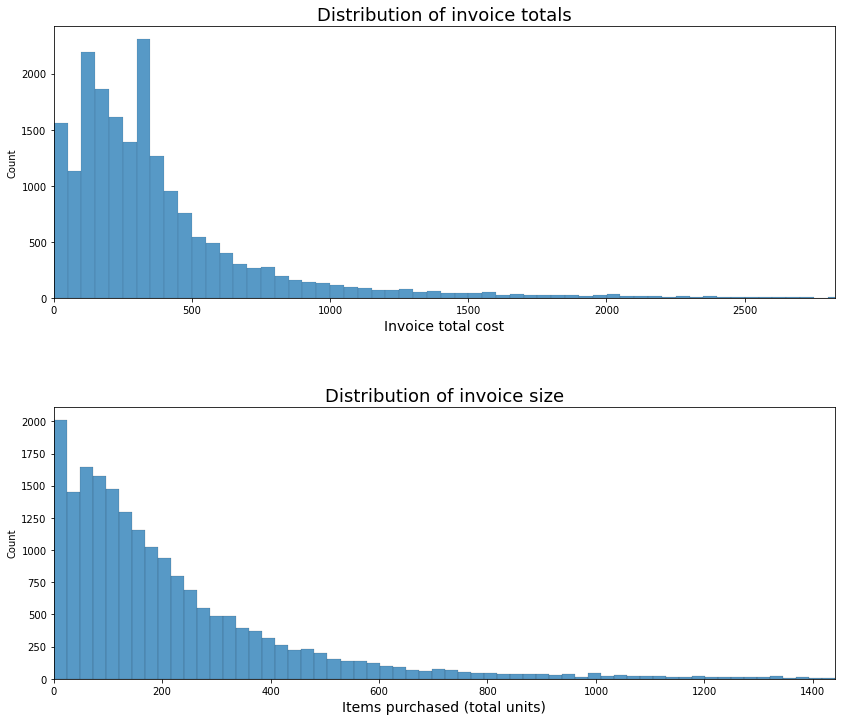

In [140]:
# Two subplots for easy comparison of invoice total & size dists
fig, (ax1,ax2)=plt.subplots(nrows = 2, figsize=(14,12))
plt.subplots_adjust(hspace=.4)

# Plot histograms 
t1 = 'Distribution of invoice totals'
t2 = 'Distribution of invoice size'
hist_plots(invoice_data, ax1,'invoice_total', 50, t1)
hist_plots(invoice_data, ax2,'total_units', 24, t2)
ax1.set_xlabel('Invoice total cost', size=14)
ax2.set_xlabel('Items purchased (total units)', size=14)

plt.show()

In [141]:
max_inv_total = invoice_data['invoice_total'].max()
invoice_data[invoice_data.invoice_total == max_inv_total]


week  customer  invoice  invoice_total  cat_ct  subcat_ct  \
1245 2019-10-31         0   574941       52940.94      20         38   

      product_ct  total_units   avg_units  cost_per_product  cost_per_unit  
1245         101        14149  140.089109        524.167723       3.741674

In [142]:
max_units = invoice_data['total_units'].max()
invoice_data[invoice_data.total_units == max_units]

week  customer  invoice  invoice_total  cat_ct  subcat_ct  \
1535 2019-06-13     12415   556917       22775.93      19         49   

      product_ct  total_units   avg_units  cost_per_product  cost_per_unit  
1535         137        15049  109.050725        166.247664       1.513451

Both invoice size & total skew heavily to the right, though they are distributed differently.

Totals have peak ranges. The 0-50 range starts strong, immediately drops in 50-100, then roughly doubles at 100-150. The frequency slowly declines, but finally hit the top frquency at 300-350. It is possible that there is some sort of incentive to reach a minumum order of 300, such as a waived shipping fee.

The number of items purchased actually peaks at only 0-24 units. Then overall has a fairly smooth declining distribution.

The highest priced invoice totals at almost 53k with 14k units; while the largest invoice contains 15k units, but only totals at 22.8k net sales with a unit cost that is less than half of the former invoice. The types of products purchased clearly have an effect on the totals.

In [143]:
total_99q = invoice_data.invoice_total.quantile(0.99)
unit_99q = invoice_data.total_units.quantile(0.99)

top1p_total = invoice_data[invoice_data.invoice_total > total_99q]
top1p_unit = invoice_data[invoice_data.total_units > unit_99q]
ct_1p = top1p_total.shape[0]

print('Total invoice count:', invoice_data.shape[0])
print('1% invoice count:', ct_1p)
print('\nRange of top 1% invoices by sales')
print('Min:', total_99q.round(2), 
      '\nMax:',top1p_total.invoice_total.max())
print('\nRange of top 1% invoices by size')
print('Min:', int(unit_99q),
      '\nMax:',top1p_unit.total_units.max())


Total invoice count: 19699
1% invoice count: 197

Range of top 1% invoices by sales
Min: 4390.57 
Max: 52940.94

Range of top 1% invoices by size
Min: 2215 
Max: 15049


The top 1% of invoices in either size or total account for an incredibly wide range of values. 

[Return to Table of Contents](#toc)

<a class='anchor' id='cust_profile'></a>
### 5.3 Customer invoice profiles

Look into customers' ordering patterns. Do we have repeat customers in this time frame? How much do they spend total? On average?

Remove data without a customer id, since we cannot determine which invoices are from repeat customers or not.

In [144]:
# Remove unidentified customers
cust_inv = invoice_data[invoice_data.customer != 0]
# Aggregate invoice metrics for each customer
cust_profile = (cust_inv.groupby('customer')
                     .agg({'invoice_total':['count','mean','sum'],
                           'product_ct':'mean',
                           'total_units':'mean'}
                         )
                     .reset_index()
               )
#Rename columns
cols=['customer','invoice_ct','avg_total',
      'net_total','avg_prods','avg_units']
cust_profile.columns = cols
#Round values
round_cols = ['avg_total','net_total','avg_prods','avg_units']
cust_profile[round_cols] = cust_profile[round_cols].round(2)

cust_profile.head(10)

customer  invoice_ct  avg_total  net_total  avg_prods  avg_units
0     12347           7     615.71    4310.00      26.00     351.14
1     12348           4     359.31    1437.24       5.75     583.00
2     12349           1    1457.55    1457.55      72.00     630.00
3     12350           1     294.40     294.40      16.00     196.00
4     12352           8     263.21    2105.71       8.88      58.25
5     12353           1      89.00      89.00       4.00      20.00
6     12354           1    1079.40    1079.40      58.00     530.00
7     12355           1     459.40     459.40      13.00     240.00
8     12356           3     829.14    2487.43      19.33     524.33
9     12357           1    6207.67    6207.67     131.00    2708.00

In [145]:
# Separate repeat customer and one-time customers
repeat_cust = cust_profile[cust_profile.invoice_ct > 1]
onetime_cust = cust_profile[cust_profile.invoice_ct == 1]

#Customer counts for each
ot_cust_ct = onetime_cust.customer.nunique()
repeat_cust_ct = repeat_cust.customer.nunique()

print('Number of one-time customers:',ot_cust_ct)
print('Number of repeat customers:',repeat_cust_ct)

Number of one-time customers: 1501
Number of repeat customers: 2822


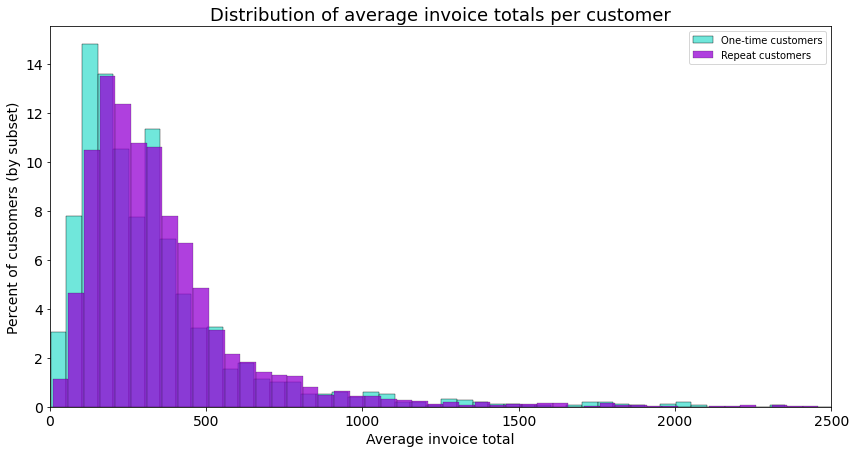

In [146]:
fig, ax = plt.subplots(figsize=(14,7))

sns.histplot(data = onetime_cust,
             x = 'avg_total',
             color='turquoise',
             stat='percent',
             binwidth = 50,
             label = 'One-time customers')
sns.histplot(data = repeat_cust, 
             x = 'avg_total',
             color='darkviolet',
             stat='percent',
             binwidth = 50,
             label = 'Repeat customers'
             )

ax.set_xlim([0,2500])

ax.set_title('Distribution of average invoice totals per customer', size=18)
ax.set_xlabel('Average invoice total', size=14)
ax.set_ylabel('Percent of customers (by subset)', size=14)
ax.tick_params(labelsize=14)

plt.legend()
plt.show()

One-time customers are more likely to have invoice totalling under 150. They also follow a more extreme dip right before spending 300, with a less extreme jump afterwards.

The average spent by repeat customers is less susceptible to this effect around 300. They are more likely to average in the 200-500 range than one-time customers.

In [147]:
rpt_cust_list = repeat_cust.customer.unique()

toptotal_rpt = top1p_total[top1p_total.customer.isin(rpt_cust_list)].shape[0]
topunit_rpt = top1p_unit[top1p_unit.customer.isin(rpt_cust_list)].shape[0]

print('Invoices w repeat customers in top 1% of invoices')
print('by total: {:.2%}'.format(toptotal_rpt/ct_1p))
print('by size: {:.2%}'.format(topunit_rpt/ct_1p))


Invoices w repeat customers in top 1% of invoices
by total: 65.99%
by size: 89.34%


Repeat customers account for the majority of both the top 1% of orders by sales and by volume. However, they account for many more of the largest orders by volume. 

[Return to Table of Contents](#toc)

<a class='anchor' id='unit_dist'></a>
### 5.4 Distribution of product quantities

Explore item quantities.

#### 5.4.1 Distribution of all sales quantities

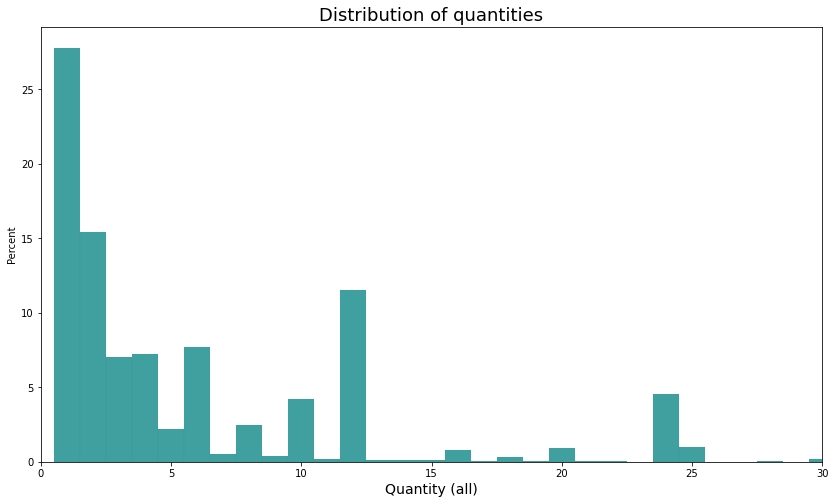

In [148]:
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.histplot(data = sales_cat,
                  x = 'quantity',
                  stat='percent',
                  color = 'teal',
                  discrete=True
                 )
ax.set_title('Distribution of quantities', size = 18)
ax.set_xlabel('Quantity (all)', size=14)
#Set xlim to cover 95% of values
xmax = sales_cat['quantity'].quantile(0.95)
ax.set_xlim([0,xmax])

plt.show()

Purchasing individual items accounts for more than a quarter of all sales. Buying in pairs, intervals of 4, or 6 is also common.

#### 5.4.2 Product quantities and order frequency

Explore whether products are purchased in high or low amounts on average and how often they are purchased.

In [149]:
# Avg quantity & number of purchases per product
product_quant = sales_cat.groupby('name')['quantity'].agg(['mean', 'count']).reset_index()
product_quant['mean'] = product_quant['mean'].round(1)
product_quant.columns = ['name','avg_quantity','purchase_freq']

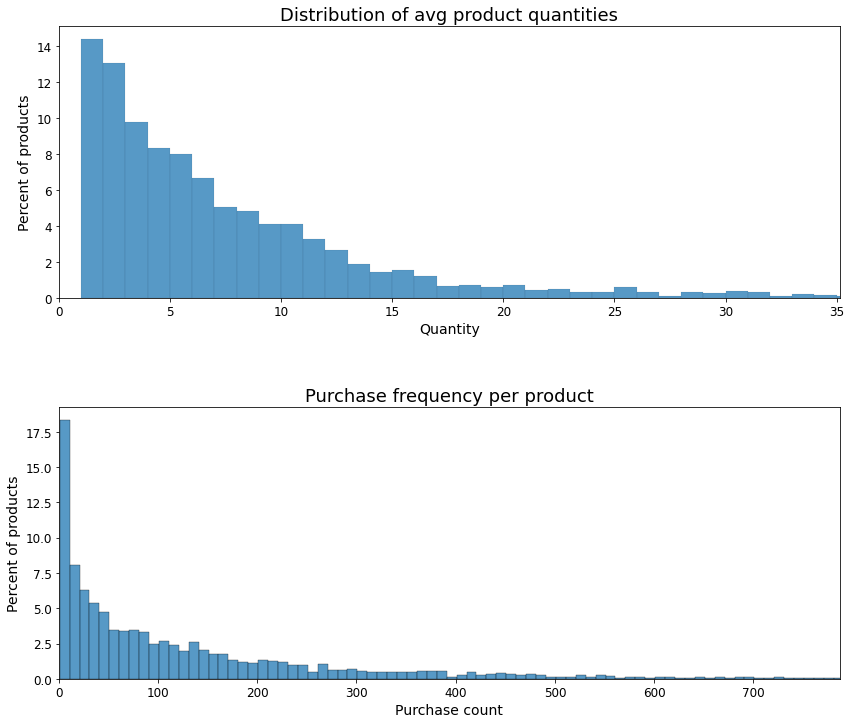

In [150]:
# Plot avg quantities & order frequency
fig, (ax1,ax2)=plt.subplots(nrows = 2, figsize=(14,12))
plt.subplots_adjust(hspace=.4)

#Plotty plot plot
sns.histplot(data = product_quant,
             x = 'avg_quantity',
             ax = ax1,
             stat='percent',
             binwidth=1
             )
sns.histplot(data = product_quant, 
             x = 'purchase_freq',
             ax = ax2,
             stat='percent',
             binwidth=10
             )
#Set xlim tpo cover 98% of values
xmax1 = product_quant['avg_quantity'].quantile(0.98)
ax1.set_xlim([0,xmax1])
xmax2 = product_quant['purchase_freq'].quantile(0.98)
ax2.set_xlim([0,xmax2])

ax1.set_xlabel('Quantity', size=14)
ax2.set_xlabel('Purchase count', size=14)

t1 = 'Distribution of avg product quantities'
t2 = 'Purchase frequency per product'
ax1.set_title(t1, size=18)
ax2.set_title(t2, size=18)

for ax in [ax1, ax2]:
    ax.tick_params(labelsize=12)
    ax.set_ylabel('Percent of products', size=14)

plt.show()

Most products are ordered in low quantities on average. Individual purchases are the most common; and the average quantity declines in frequency at an almost steady rate.

Purchase frequency is also generally low, with roughly 18% items purchased fewer than 10 times. Though roughly 40% of items have frequencies ranging from 10-100. Even up to 200 purchases isn't too uncommon.

#### 5.4.3 Product quantities in relation to order frequency

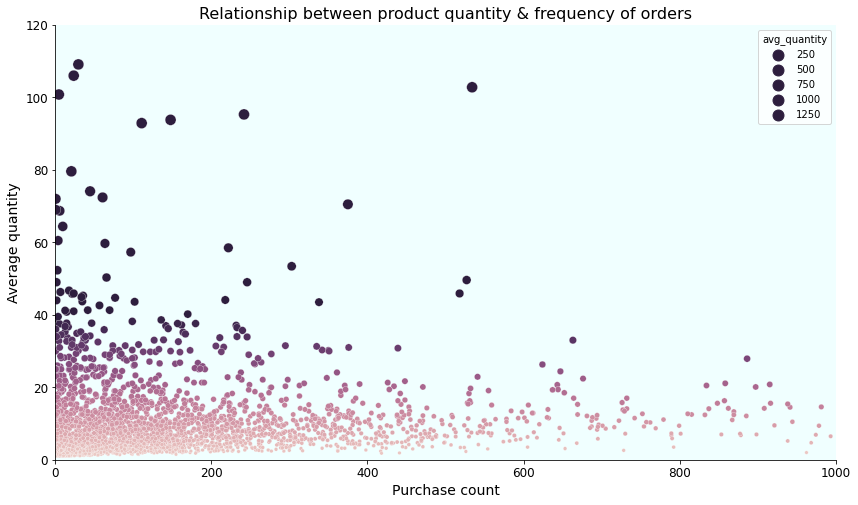

In [151]:
fig = plt.figure(figsize=(14,8))

ax = sns.scatterplot(data = product_quant,
                     x='purchase_freq',
                     y='avg_quantity',
                     hue = 'avg_quantity',
                     hue_norm = (0,40),
                     size = 'avg_quantity',
                     sizes = (10,120),
                     size_norm = (0,80),
                    )
ax.set_title('Relationship between product quantity & frequency of orders', size=16)
ax.set_xlim([0,1000])
ax.set_ylim([0,120])

ax.set_xlabel('Purchase count',size=14)
ax.set_ylabel('Average quantity',size=14)
ax.tick_params(labelsize=12)

ax.set_facecolor('azure')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()


Overall, items that tend to be ordered in higher quantities seem to be ordered less frequently. Though there are certainly exceptions. This is likely based on product type. For example: set of 12 individually packaged string lights is likely to be purchased less often than a set of 60 pens.

[Return to Table of Contents](#toc)

<a class='anchor' id='totals_rel'></a>
### 5.5 Relationship between invoice total, units purchase, and unique products

First, we will remove invoices totalling over 5000 in sales and containing over 2300 units. These account for less than 1% of invoices, but contain extreme outliers.

In [152]:
#Remove extreme outliers f
invoice_outliers = invoice_data[(invoice_data.total_units >= 2300)|(invoice_data.invoice_total >= 5000)].copy()
invoice_norm = invoice_data[(invoice_data.total_units < 2300) & ((invoice_data.invoice_total < 5000))].copy()

##### Plot the relationship 

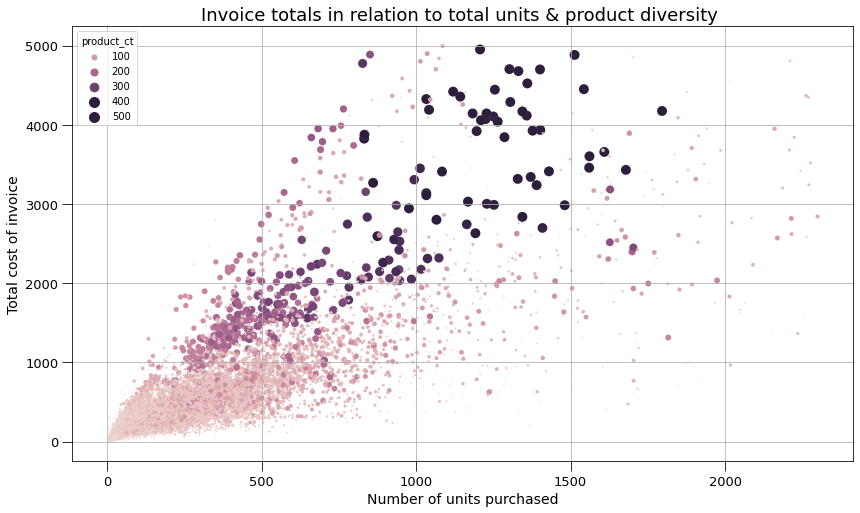

In [153]:
fig = plt.figure(figsize=(14,8))

ax = sns.scatterplot(data = invoice_norm,
                     x = 'total_units',
                     y = 'invoice_total',
                     hue ='product_ct',
                     hue_norm=(0,400),
                     size='product_ct',
                     sizes = (0,100),
                     size_norm = (0,400)
                    )


plt.title('Invoice totals in relation to total units & product diversity ', size=18)
plt.ylabel('Total cost of invoice', size=14)
plt.xlabel('Number of units purchased', size=14)
plt.tick_params(size=10,labelsize=13)

plt.grid()
plt.show()

There tends to be a lot of variety between each order's volume & sales, though the product diversity does seem to play a role.

Invoices with a large number of unique products (represented by the dark markers on the graph) seem to include more high-price items. This contributes to higher average prices, and therefore higher overall sales per order.

Invoices with low diversity vary much more. There does appear to be a subset of invoices with fewer high-priced products being purchased in high amounts. On the other end, there are also large invoices with high quantities of much cheaper products. It really seems to depend again on the product type.

[Return to Table of Contents](#toc)

<a class='anchor' id='outlier_cust'></a>
### 5.6 Outlier vs standard customers

Identify customers responsible for the outlier invoices. Investigate their behaviors.

In [154]:
#List of invoices in the invoice_outliers
outlier_invoice_num = invoice_outliers['invoice']
#List of standard invoices
normal_invoice_num = invoice_norm['invoice']

#All sales included in outlier invoices
outlier_sales = sales_cat[sales_cat.invoice.isin(outlier_invoice_num)]
#All sales included in standard invoices
normal_sales = sales_cat[sales_cat.invoice.isin(normal_invoice_num)]

#Customers responsible for outlier invoices & the number of 
outlier_cust = (outlier_sales[outlier_sales['customer']!=0].groupby('customer')['invoice']
                                                           .nunique()
                                                           .reset_index()
                                                           .rename(columns={'invoice':'big_order'})
               )
#Add big_order cts to customer profile
cust_profile = (cust_profile.merge(outlier_cust,
                                  how='left',
                                  on='customer')
                            .fillna(0)
               )

only_big = cust_profile[cust_profile['big_order']==cust_profile['invoice_ct']]
big2 = cust_profile[cust_profile['big_order']>1]

print('Total number of customers with big purchases:', outlier_cust.customer.nunique())
print('Customers who have only made big purchases:', only_big.shape[0])
print('Customers who have made multiple big purchases', big2.customer.nunique())

Total number of customers with big purchases: 58
Customers who have only made big purchases: 10
Customers who have made multiple big purchases 26


Large purchases are overwhelmingly made by repeat customers. Almost half of these customers have made more than one big purchase.

[Return to Table of Contents](#toc)

<a class='anchor' id='cat'></a>
## 6. Category Analysis

Explore the performance & trends of different categories

In [155]:
# Remove fees and unknown items
to_drop = ['UNKNOWN','FEES']
sales_prods = sales_cat[~(sales_cat.isin(to_drop))].copy()

In [156]:
#Aggregate data on categories
category_data = sales_prods.groupby(['category']).agg({'code':'nunique',
                                                       'invoice':'nunique',
                                                       'quantity':['mean','sum'],
                                                       'u_price': 'mean',
                                                       'total': ['mean','sum'],
                                                    }).reset_index()
category_data.columns = ['category','unique_products','purchases','avg_units_sold','total_units_sold',
                         'avg_unit_price','avg_sales','total_sales']
category_data.head(3)

category  unique_products  purchases  avg_units_sold  \
0    ACCESSORIES               86       2147       10.242228   
1   ART SUPPLIES               89       5320       13.315149   
2  BAGS & PURSES              144       6482        9.833096   

   total_units_sold  avg_unit_price  avg_sales  total_sales  
0             64905        1.171127   6.486514     41105.04  
1            182817        1.537983  13.275476    182272.28  
2            193417        2.592003  16.142060    317514.33

[Return to Table of Contents](#toc)

<a class='anchor' id='cat_corr'></a>
### 6.1 Relationships between category metrics

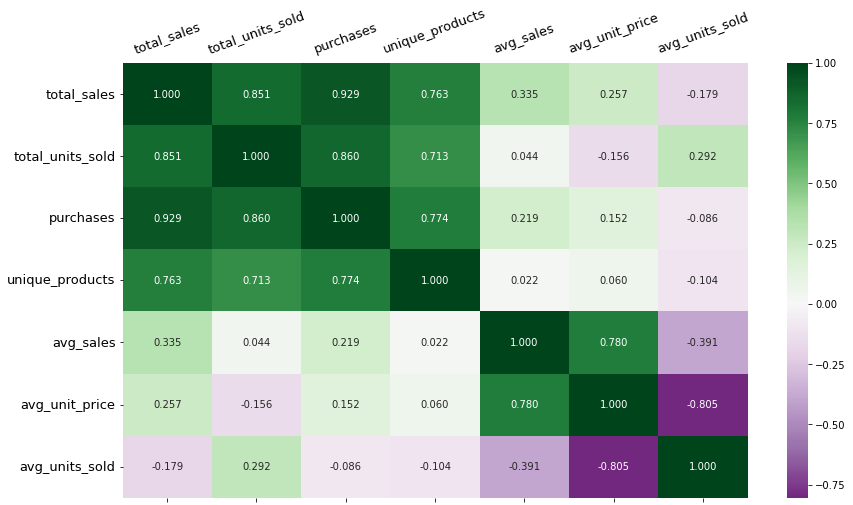

In [157]:
# Create corr matrix of all category_data calcs
order=['total_sales','total_units_sold','purchases','unique_products',
       'avg_sales','avg_unit_price','avg_units_sold']
category_corr = category_data[order].corr()

#Plot heatmap of corr matrix
fig = plt.figure(figsize=(14,8))
sns.heatmap(category_corr,
            cmap = 'PRGn', center = 0,
            annot = True, fmt = '.3f'
           )

plt.tick_params(axis = 'both',labelsize = 13,
                labeltop = True, labelbottom = False
               )
plt.xticks(rotation = 20)
plt.show()


Total revenue of a product is more strongly influenced by the frequency of sales than overall units sold; though there is still a strong relationship there.

There is a moderate negative relationship between a category's average unit price and the average number of units sold per order. Less expensive items are generally purchased in larger quantities.

#### Relationship between each category's total sales & units sold

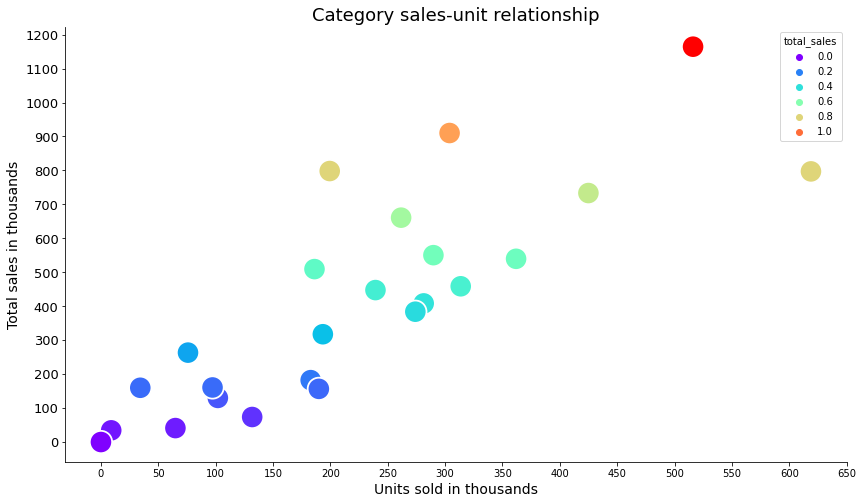

In [158]:
#Plotty plot plot
fig = plt.figure(figsize=(14,8))

ax = sns.scatterplot(data = category_data,
                x = 'total_units_sold',
                y = 'total_sales',
                hue= 'total_sales',
                palette = 'rainbow',
                s = 500)


plt.title('Category sales-unit relationship', size=18)
plt.xlabel('Units sold in thousands', size=14)
plt.ylabel('Total sales in thousands', size=14)

xticks = np.arange(0,700000,50000)
xlabels = (xticks/1000).astype(int)
plt.xticks(ticks=xticks, labels = xlabels)

yticks = np.arange(0,1300000,100000)
ylabels = (yticks/1000).astype(int)
plt.yticks(ticks = yticks, labels = ylabels, size=13)

sns.despine()
plt.show()

Here we can more clearly see the large differenc between category sizes. While there is an overall relationship between units sold and sales, our top sales category is not the category with the most units sold.

Next we will take a deeper look into the categories.

[Return to Table of Contents](#toc)

<a class='anchor' id='top10_cats'></a>
### 6.2 Overall top 10 categories

<a class='anchor' id='top10_overall'></a>
#### 6.2.1 Top 10 categories by overall sales

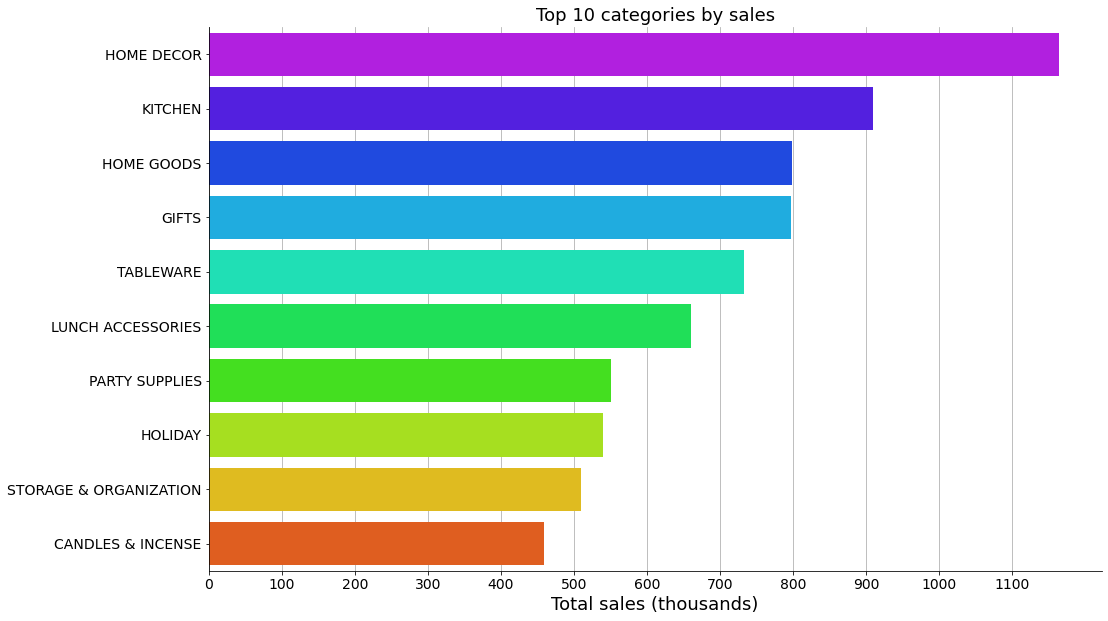

In [159]:
top10_cat=category_data.sort_values('total_sales',ascending=False).head(10).copy()
top10_cat['category'] = top10_cat['category'].astype('string')


fig = plt.figure(figsize=(16,10))

sns.barplot(data=top10_cat,
            x='total_sales',
            y='category',
            palette='gist_rainbow_r',
            zorder=2
           )

plt.title('Top 10 categories by sales', size=18)

plt.tick_params(labelsize=14)
xticks = np.arange(0,1200000,100000)
xlabels = (xticks/1000).astype(int)
plt.xticks(ticks=xticks, labels = xlabels)

plt.xlabel('Total sales (thousands)', size=18)
plt.ylabel('')

sns.despine()
plt.grid(axis='x',zorder=0)
plt.show()

Home Decor is the dominant category, bringing in over 1.1 million in revenue. Kitchen goods are next, though this does not even include Tableware which is also in the top 10.

9 of the 10 categories brought in over half a million in revenue each.

[Return to Table of Contents](#toc)

<a class='anchor' id='top10_monthly'></a>
#### 6.2.2 Top 10 category monthly trends

In [160]:
# List of top categories
top_cats = top10_cat['category'].unique()
# All sales data from the top 10 categories
topcat_sales = sales_cat[sales_cat.category.isin(top_cats)]
# Total monthly sales of top 10 categories
cat_monthly = topcat_sales.groupby(['category','month'])['total'].sum().reset_index()
#Remove Nov 2018 & Dec 2019. They are incomplete.
cat_monthly = cat_monthly[~(cat_monthly.month.isin(['2018-11-01','2019-12-01']))]

In [161]:
#Plot total sales of top 10 categories
fig = go.Figure()

#Add trace for each category in top 10
for cat in top_cats:
    cat_slice = cat_monthly[cat_monthly.category==cat]
    month = cat_slice['month']
    sales = cat_slice['total']
    fig.add_trace(go.Scatter(x = month,
                             y = sales,
                             name = cat)
                 )

fig.update_layout(title_text="Monthly sales by category",
                  width = 1200,
                  height = 700)

# Set x-axis title
fig.update_xaxes(title_text="")

# Set y-axes titles
fig.update_yaxes(title_text="Total sales amount")


**Home Decor** and **Holiday** items are the strongest contributers to the holiday boost in November. While **Home Decor** generally stays close to the top, gift giving seems to be a strong driving force for items that may generally be considered "non-essential." Meanwhile, the **Holiday** category remains low over the course of the year, with a small bump preceding Easter. Though the category grows rapidly after the Summer ends.

**Home Goods** enjoy a spike in June, followed by a major drop in August, and then a major peak in September. Though the category declines again, it still remains high compared to the rest of the year as the winter holidays approach.

**Lunch Accessories** have an interesting growth during Fall & Winter.

**Party Supplies** are largely centered around good weather in the Spring & Summer, with a peak in May. There is an additional pre-Christmas boost though.

**Gifts** seem to follow a combination of **Party** and **Holiday** categories. The majority of this category is related to gift-wrapping, so this is to be expected. 

The **Kitchen** category has a March spike, followed by a major drop in June. This should be investigated. Other than this, it seems to follow relative growth into the Winter. **Tableware** follows a similar path, though less extreme. There is somewhat of a levelling in the Summer.

**Storage & Organization** products follow a similar path as **Home Goods**, except without the hug September spike. 


[Return to Table of Contents](#toc)

<a class='anchor' id='monthly_cat_rank'></a>
### 6.3 Monthly category rankings

See if the top categories change depending on time of year.

In [162]:
#Monthly sales of each category
full_cat_monthly = (sales_cat.groupby(['category','month'])['total']
                             .sum().reset_index()
                   )
#Remove Nov 2018 & Dec 2019. They are incomplete.
full_cat_monthly = full_cat_monthly[~(full_cat_monthly.month.isin(['2018-11-01','2019-12-01']))]
# Sort by month and sales
full_cat_monthly = (full_cat_monthly.sort_values(by = ['month','total'],
                                                 ascending = [True,False])
                                    .reset_index(drop=True)
                   )
# Add monthly rank
full_cat_monthly['rank'] = full_cat_monthly.groupby('month')['total'].rank(ascending=False)

# Slice of monthly top 10
top10_monthly = full_cat_monthly[full_cat_monthly['rank'] <= 10]
# Slice of monthly top 5
top5_monthly = full_cat_monthly[full_cat_monthly['rank'] <= 5]

[Return to Table of Contents](#toc)

<a class='anchor' id='monthly_rank_top10'></a>

#### Plot the top 10 monthly category rankings

Look into top 10 categories of every month. Create a heatmap for easy visualization of rankings and prevalence of each category.

In [163]:
# Category ranks per month
category_heat = top10_monthly.pivot_table(index='category',
                                          columns='month',
                                          values='rank',
                                          aggfunc='first')

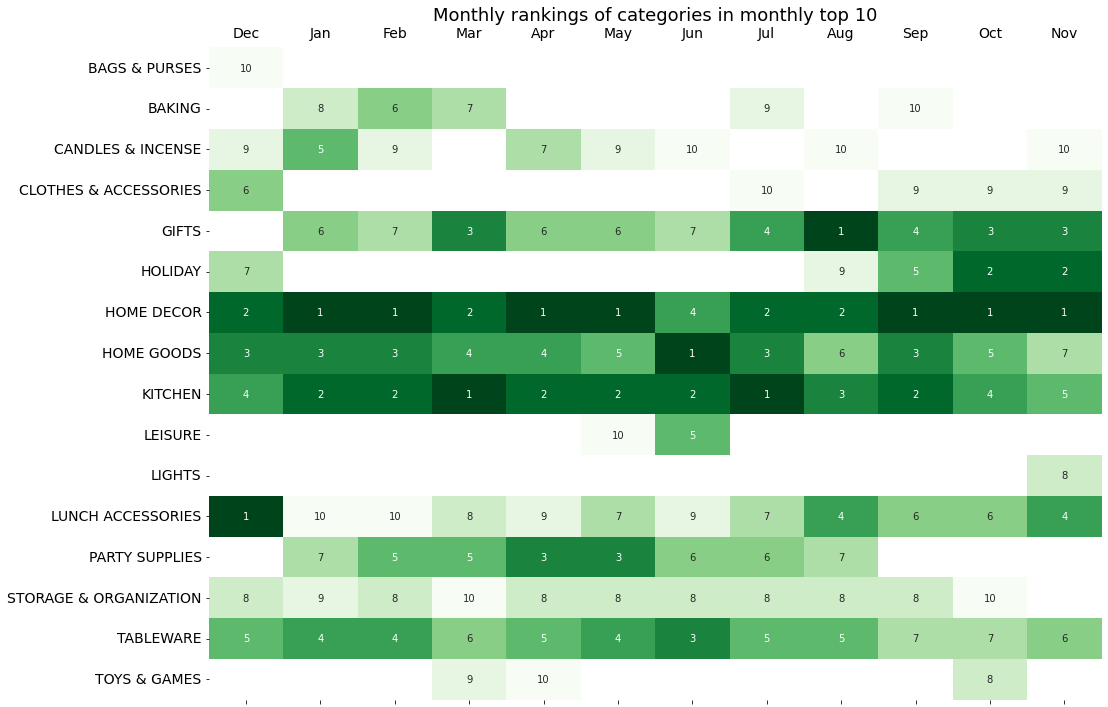

In [164]:
# Plot heatmap of monthly rankings
fig=plt.figure(figsize=(16,12))

ax = sns.heatmap(category_heat, 
                 cmap= 'Greens_r',
                 annot=True,
                 cbar=False
                )

ax.set_title('Monthly rankings of categories in monthly top 10',size=18)
ax.set_xlabel('')
ax.set_ylabel('')

months= full_cat_monthly['month'].drop_duplicates()
xticks = [item.strftime('%b') for item in months]
ax.set_xticklabels(xticks, rotation=0)
plt.tick_params(labelsize=14,
                labeltop=True,
                labelbottom=False)

plt.show()

Home Decor, Kitchen, Home Goods, Tableware, & Gifts are fairly consistent in their rankings. Though Gifts do disappear from rankings when no longer needed for Christmas.

The Holiday category is only in the top 10 for 5 months of the year, though it is so popular during that time that it still ranks 7th overall.

Lunch accessories strangely take the top spot in December; which is also th eonly months Bags & Purses appear on the rankings at all,.

[Return to Table of Contents](#toc)

<a class='anchor' id='subcat'></a>
### 6.4 Sub-category investigation

Investigate the monthly trends of the top categories. It is possible that particular subcategories can account for jumps in sales.

<a class='anchor' id='lunch'></a>
#### 6.4.1 Lunch accessories

Why are they going up in December?

In [165]:
lunch = 'LUNCH ACCESSORIES'
dec = '2018-12-01'
lunch_sales = sales_cat[sales_cat.category == lunch]
lunch_sales_dec = lunch_sales[lunch_sales.month == dec]
lunch_sales_dec.groupby('sub_cat')[['quantity','total']].sum().sort_values(by='total',ascending=False)

quantity     total
sub_cat                           
WATER BOTTLES      10952  58930.19
LUNCH BAGS          3538   6675.07
SNACK BOXES         2324   6424.76
LUNCH BOXES         2937   6130.39
ANIMAL DECOR           0      0.00
...                  ...       ...
FRIDGE MAGNETS         0      0.00
GAMES                  0      0.00
GARDEN DECOR           0      0.00
GARDEN MARKERS         0      0.00
WINDMILLS              0      0.00

[149 rows x 2 columns]

Water bottle sales in December account for most of the sales in the lunch category. Let's look at the full sales data of this subcategory compared to the rest of the Lunch Accessories category.

In [166]:
#Separate bottle & other lunch item sales
bottle_sales = lunch_sales[lunch_sales.sub_cat=='WATER BOTTLES']
other_lunch = lunch_sales[lunch_sales.sub_cat!='WATER BOTTLES']
#Group each by week, agg total sales
weekly_bottle = bottle_sales.groupby('week')['total'].sum().reset_index()
weekly_other = other_lunch.groupby('week')['total'].sum().reset_index()

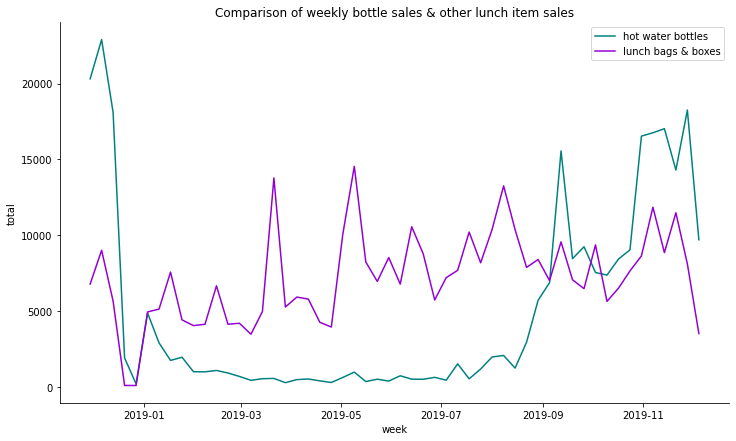

In [167]:
#Plot them lines yo
fig, ax = plt.subplots(figsize=(12,7))
#Plot weekly trend of the water bottle subcategory
sns.lineplot(data = weekly_bottle,
             x='week',y='total',
             color='teal',
             label = 'hot water bottles'
            )
#Plot trends of the remaining lunch items
sns.lineplot(data = weekly_other,
             x='week',y='total',
             color='darkviolet',
             label = 'lunch bags & boxes'
            )


ax.set_title('Comparison of weekly bottle sales & other lunch item sales')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

The Water Bottle subcategory is comprised mostly of hot water bottles. We can see these sales explode In the fall and winter, when the weather is cold. During this time, hot water bottles account for most of the sales within the whole Lunch category.

[Return to Table of Contents](#toc)

<a class='anchor' id='kitchen'></a>
#### 6.4.2 Kitchen

There is a major spike in sales in March, which plummet in April, and immediately jump back up. There is an additional large jump in September. Investigate monthly subcategory sales.

In [168]:
kitchen = 'KITCHEN'
#All kitchen sales
kitchen_sales = sales_cat[sales_cat.category == kitchen]
#List of kitchen subcategories
kitch_cats = kitchen_sales['sub_cat'].unique()
#Weekly
sc_weekly =  kitchen_sales.groupby(['sub_cat','month','week'])['total'].sum().reset_index()
#Remove Nov 2018 & Dec 2019. They are incomplete.
sc_weekly = sc_weekly[~(sc_weekly.month.isin(['2018-11-01','2019-12-01']))]

In [169]:
#Plot total sales of kitchen subcats
fig = go.Figure()

#Add trace for each category
for sc in kitch_cats:
    sc_slice = sc_weekly[sc_weekly.sub_cat==sc]
    week = sc_slice['week']
    sales = sc_slice['total']
    fig.add_trace(go.Scatter(x = week,
                             y = sales,
                             name = sc)
                 )

fig.update_layout(title_text="Weekly sales by kitchen sub-category",
                  width = 1200,
                  height = 700)

# Set x-axis title
fig.update_xaxes(title_text="")

# Set y-axes titles
fig.update_yaxes(title_text="Total sales amount")

Overall, the kitchen category seems to follow a more cyclical pattern, with a dip at the end of every month. These tend to be long-lasting items, so businesses likely purchase them in larger amounts on a less frequent basis.

In [170]:
#Look at the top 10 items in the top subcategories
mar = '2019-03-01'
subcats_UAC = ['UTENSILS','COOKWARE','KITCHEN ACCESSORIES']
kitchen_sales_mar = kitchen_sales[(kitchen_sales.month == mar)
                                  & kitchen_sales.sub_cat.isin(subcats_UAC)]

(kitchen_sales_mar.groupby(['sub_cat','name'])[['quantity','total']]
                  .sum()
                  .sort_values(by='total',ascending=False)
).head(10)

quantity     total
sub_cat             name                                                   
UTENSILS            REGENCY CAKESTAND 3 TIER                 1186  15369.54
COOKWARE            JAM MAKING SET WITH JARS                  935   3997.61
KITCHEN ACCESSORIES SET 2 TEA TOWELS I LOVE LONDON           1122   3088.50
COOKWARE            JAM MAKING SET PRINTED                   1622   2719.40
KITCHEN ACCESSORIES RECIPE BOX PANTRY YELLOW DESIGN           662   2083.60
                    SET 2 PANTRY DESIGN TEA TOWELS            498   1612.30
UTENSILS            PANTRY WASHING UP BRUSH                   831   1375.06
                    PANTRY ROLLING PIN                        340   1258.99
                    PANTRY SCRUBBING BRUSH                    708   1177.34
KITCHEN ACCESSORIES SET OF 2 TEA TOWELS APPLE AND PEARS       331    986.93

The March boost seems to occur across most subcategories, but most notably Utensils, Accessories, and Cookware. There is no obvious cause. This could just be due to, though jam making accessories seem to be prevalent. This could be related to the seasonality of many jam-making fruits during the spring. The approach of Easter and better weather may contribute to more picnics and larger shared meals.


In [171]:
#Look into popular food storage items during the Sept peak
fs ='FOOD STORAGE'
sep = '2019-09-01'
fs_sales = sales_cat[sales_cat.sub_cat == fs]
fs_sales_sep = fs_sales[fs_sales.month == sep]
fs_sales_sep.groupby('name')[['quantity','total']].sum().sort_values(by='total',ascending=False).head(15)

quantity    total
name                                                  
SET OF TEA COFFEE SUGAR TINS PANTRY      2051  9870.73
SET OF 6 SPICE TINS PANTRY DESIGN        1111  4597.07
BREAD BIN DINER STYLE IVORY               153  2270.49
BOX OF 6 MINI 50S CRACKERS                828  1901.83
BOX OF 6 MINI VINTAGE CRACKERS            745  1719.78
REGENCY SUGAR BOWL GREEN                  331  1365.73
BREAD BIN DINER STYLE RED                  85  1230.23
ENAMEL BREAD BIN CREAM                     92  1184.36
CLASSIC GLASS SWEET JAR                   248  1041.80
SET 3 RETROSPOT TEA COFFEE SUGAR          192   959.84
GLASS BON BON JAR                         398   672.46
SET OF 4 JAM JAR MAGNETS                  324   652.47
CLASSIC SUGAR DISPENSER                   453   649.35
LARGE CERAMIC TOP STORAGE JAR             318   525.06
RED SPOTTY BISCUIT TIN                     95   475.91

Popular food storage items in September seem to revolve around sweets, biscuits, & coffee. This is the time of year where more people are indoors, sitting for tea/coffee with friends & family. The focus on serving tea time at home may push the desire for nice organizational/serving items.

[Return to Table of Contents](#toc)

<a class='anchor' id='home_decor'></a>
#### 6.4.3 Home Decor

In [172]:
hd = 'HOME DECOR'
#All home decor sales
hd_sales = sales_cat[sales_cat.category == hd]
#List of HD subcategories
hd_cats = hd_sales['sub_cat'].unique()
#Weekly
hd_monthly =  hd_sales.groupby(['sub_cat','month'])['total'].sum().reset_index()
#Remove Nov 2018 & Dec 2019. They are incomplete.
hd_monthly = hd_monthly[~(hd_monthly.month.isin(['2018-11-01','2019-12-01']))]

In [173]:
#Plot total sales of Home Decor subcats
fig = go.Figure()

#Add trace for each subcategory 
for sc in hd_cats:
    sc_slice = hd_monthly[hd_monthly.sub_cat==sc]
    month = sc_slice['month']
    sales = sc_slice['total']
    fig.add_trace(go.Scatter(x = month,
                             y = sales,
                             name = sc)
                 )

fig.update_layout(title_text="Monthly sales by Home Decor sub-category",
                  width = 1200,
                  height = 700)

# Set x-axis title
fig.update_xaxes(title_text="")

# Set y-axes titles
fig.update_yaxes(title_text="Total sales amount")

Investigate the sales spikes in top subcategories in the fall more closely.

In [174]:
fall = ['2019-09-01','2019-10-01','2019-11-01']

subcats_topHD = ['SIGNS & WALL ART','PICTURE FRAMES','CLOCKS','HEART DECOR']
hd_sales_fall = (hd_sales[hd_sales.month.isin(fall)
                 & hd_sales.sub_cat.isin(subcats_topHD)])

fall_weekly_hd = hd_sales_fall.groupby(['sub_cat','week'])['total'].sum().reset_index()


In [175]:
#Plot total sales of top 10 categories
fig = go.Figure()

#Add trace for each category
for sc in subcats_topHD:
    sc_slice = fall_weekly_hd[fall_weekly_hd.sub_cat==sc]
    week = sc_slice['week']
    sales = sc_slice['total']
    fig.add_trace(go.Scatter(x = week,
                             y = sales,
                             name = sc)
                 )

fig.update_layout(title_text="Weekly sales by Home Decor sub-category",
                  width = 1000,
                  height = 600)

# Set x-axis title
fig.update_xaxes(title_text="")

# Set y-axes titles
fig.update_yaxes(title_text="Total sales amount")

In [176]:
art ='SIGNS & WALL ART'
art_sales = sales_cat[(sales_cat.sub_cat == art) &(sales_cat.month == sep)]
art_sales.groupby('name')[['quantity','total']].sum().sort_values(by='total',ascending=False).head()

quantity    total
name                                              
PLEASE ONE PERSON METAL SIGN         2531  5047.89
COOK WITH WINE METAL SIGN            2064  4184.37
HOT BATHS METAL SIGN                 1327  3057.05
GIN TONIC DIET METAL SIGN            1005  2512.55
METAL SIGN HER DINNER IS SERVED       785  2511.27

Generally, wall art accounts for the largest portion of the Home Decor category. This category experiences extraordinary growth from September into the holiday season. All the decor items can generally be purchased as gifts.

Picture frames experience the most growth mid-October. This would be the time that school portraits would be sent home, and just preceding family holiday photos.

There is no obvious reason for the large amounts of metal signs purchased in September.

[Return to Table of Contents](#toc)

<a class='anchor' id='hyp_test'></a>
## 7. Hypothesis Testing

<a class='anchor' id='subcat_totals'></a>
### 7.1 Subcategory diversity on invoice totals

**Null hypothesis:** The rate of subcategories to total products does relate to total revenue of the invoice.

**Alternative hypothesis:** A higher rate of subcategories to total products correlates to higher invoice totals.

Small invoices will have lower rates of both, so first filter for only larger invoices. Based on [this graph](#totals_rel), we will filter out invoices with fewer than 250 units.

In [177]:
large = invoice_data.total_units > 250
cols = ['invoice', 'week', 'invoice_total','subcat_ct','product_ct']

invoice_div = invoice_data[large].copy()
invoice_div = invoice_div[cols]
invoice_div['div_rate'] = invoice_div['subcat_ct']/invoice_div['product_ct']

In [178]:
corr = invoice_div['div_rate'].corr(invoice_div['invoice_total'])

print('The correlation between product diversity & invoice totals: {:.3f}'.format(corr))

The correlation between product diversity & invoice totals: -0.166


There is no clear linear relationship present.

[Return to Table of Contents](#toc)

<a class='anchor' id='holiday_div'></a>

### 7.2 Holiday invoice diversity

**Null hypothesis:** Fall invoices (Sept through the end of the year) have similar product counts to the rest of the year.

**Alternative hypothesis:** Fall invoices contain more products than invoices during the rest of the year.

In [179]:
invoice_fall = invoice_div[invoice_div.week >= sep]['product_ct'].reset_index(drop=True)
invoice_other = invoice_div[invoice_div.week < sep]['product_ct'].reset_index(drop=True)

results = st.mannwhitneyu(invoice_fall, invoice_other)
pvalue = results.pvalue

print('The p-value is {:.4f}.'.format(pvalue))
if pvalue <.05:
    print('We reject the null hypothesis. There is a signficant difference product counts')
else:
    print('We fail to reject the null hypothesis. There is no significant difference between product counts')
print()    
print('The relative difference in average product count for autumn: {0:.2f}'
      .format(invoice_fall.mean()/invoice_other.mean()-1)
     )

The p-value is 0.0000.
We reject the null hypothesis. There is a signficant difference product counts

The relative difference in average product count for autumn: 0.13


[Return to Table of Contents](#toc)

<a class='anchor' id='subcat_freq'></a>

### 7.3 Subcategory size & order frequency

**Null hypothesis:** Subcategory size is not related to order frequency.

**Alternative hypothesis:** Subcategory size is related to order frequency.

In [180]:
subcat_orders = sales_cat.groupby('sub_cat')[['name','invoice']].nunique()
subcat_orders.columns = ['product_ct','order_ct']
subcat_orders.head()

product_ct  order_ct
sub_cat                                         
ANIMAL DECOR                        36      1193
BABY                                13       856
BACKPACKS & CHILDRENS BAGS           7       480
BAG CHARMS                          19       193
BAKING CASES                        27      4035

In [181]:
corr = subcat_orders['product_ct'].corr(subcat_orders['order_ct'])

print('The correlation between subcategory size & order frequency: {:.3f}'.format(corr))

The correlation between subcategory size & order frequency: 0.631


There is a moderate relationship between the size of a subcategory and order frequency.

[Return to Table of Contents](#toc)

<a class='anchor' id='conclusions'></a>
## Conclusions

First, I strongly recommend a clearer system of labelling. Inventory adjustments and sales should be stored differently at the very least. One solution would be to have a separate invoice marker, the same way credit invoices begin with 'C'. I would also recommend separating 'description' into two separate fields: 'product name' and 'notes'. This will allow a faster, smoother interpretation of the data. I would additionally recommend a drop down list of preset values for common explanations.

The website likely has defined category & subcategory names. Including this table would save a lot of time, especially since the product names are not always clear.

Seasonal trends play a large role in sales. In general, sales tend to increase in Autumn, partly in anticipation of the winter holidays. Most categories experience large sales growth during this time. Businesses don't just purchase more units though--orders during this time container a broader range of items. It is important to prepare for this by not only acquiring extra stock, but by diversifying the options available across all categories.

It is important to continue tracking sales by both category and subcategory. This will allow us to anticipate sudden changes in demand over the course of the year, and therefore keep our products more relevant. While categories related to the home (decor, kitchen, tableware, storage) remain popular throughout the year, other categories are more susceptible to seasonal changes. Party supplies, for example, are much more popular in Spring and Summer when the weather is more comfortable for large outdoor parties that require paper goods. Leisure items similary rank highest in May & June when outdoor weather is more enjoyable. Creating a calendar that prioritizes specific holidays and changes in season will allow for the best inventory planning. When subcategories are trending, that is when we should focus on adding variety to those subcategories. More options lead to more sales.

[Return to Table of Contents](#toc)

## For tableau

In [182]:
#Download relevant data for Tableau
tab_data = sales_cat[['name','category','invoice','date','total']]
#tab_data.to_csv('ecomm_cat.csv')